In [3]:
%matplotlib inline
import numpy as np
import pandas as pd

from dask.distributed import Client
import distributed

from condor_utils import make_htcondor_cluster
from dask.distributed import Client, progress
#from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler

import utils
import glob
import uproot4
import awkward1 as ak
from yahist import Hist1D
from yahist import Hist2D

import matplotlib.pyplot as plt

#import uproot_methods

utils.bokeh_output_notebook()

Loading BokehJS ...

In [4]:
import mplhep as hep
plt.style.use([hep.style.CMS])

In [5]:
cluster = make_htcondor_cluster(local=False, dashboard_address=13349)
cluster

In [6]:
cluster.scale(100)

In [7]:
c = Client(cluster)
c

Client Scheduler: tcp://169.228.130.5:12165 Dashboard: http://169.228.130.5:13349/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [ ]:
c.restart()

In [ ]:
c.shutdown()

In [5]:
def initialize_arraycache():
    from distributed import get_worker
    import uproot
    worker = get_worker()
    worker.cache = uproot.ArrayCache("6 GB")
    worker.treecache = {}
    
c.run(initialize_arraycache);

In [6]:
def cachesize_metric():
    def f(worker):
        if hasattr(worker,"cache"):
            return "{:.2f}GB".format(worker.cache._cache.currsize/1e9)
        return 0
    return f

def treecache_metric():
    def f(worker):
        if hasattr(worker,"treecache"):
            return len(list(worker.treecache.keys()))
        return 0
    return f

def register_metrics(dask_worker):
    dask_worker.metrics["cachesize"] = cachesize_metric()
    dask_worker.metrics["treecache"] = treecache_metric()

c.run(register_metrics);

In [8]:
%%time
futures = c.map(lambda x:x, range(100),pure=False)
np.array(c.gather(futures)).shape

CPU times: user 13.1 s, sys: 1.94 s, total: 15 s
Wall time: 8min 47s


(100,)

In [10]:
%%time
fnames = sorted(glob.glob("/hadoop/cms/store/user/hmei/rawreco_runII/zerobias/ZeroBias_Run2018D-LogError-PromptReco-v2_RAW-RECO_v0.1_20201108/*root"))[:-1]
#fnames = sorted(glob.glob("/hadoop/cms/store/user/hmei/rawreco_runII/zerobias/ZeroBias_Run2018D-LogError-PromptReco-v2_RAW-RECO_v0.1_20201027/*root"))[:-1]
chunks, total_nevents = utils.get_chunking(tuple(fnames),int(1.0e6),treename="cscRootMaker/Events",skip_bad_files=True)
print("{} chunks of {} files, with a total of {:.5g} events".format(len(chunks),len(fnames),total_nevents))

#import csv

#import ast
#with open('chunklist_2018D_zerobias.csv', newline='') as f:
#    reader = csv.reader(f)
#    chunks = list(reader)
#
#chunks = [ast.literal_eval(i) for i in chunks[0]]
#chunks

332 chunks of 332 files, with a total of 5.2599e+06 events
CPU times: user 6.76 ms, sys: 1.2 ms, total: 7.95 ms
Wall time: 90.2 ms


In [7]:
chunks[0]

('/hadoop/cms/store/user/hmei/rawreco_runII/zerobias/ZeroBias_Run2018D-LogError-PromptReco-v2_RAW-RECO_v0.1_20201108/test_rawreco_10.root',
 0,
 16634)

In [ ]:
#fnames = sorted(glob.glob("/hadoop/cms/store/user/hmei/rawreco_runII/zerobias/ZeroBias_Run2018D-LogError-PromptReco-v2_RAW-RECO_v0.1_20201103/*root"))[:-1]
#def getChunks(fnames):
#    #fnames = sorted(glob.glob("/hadoop/cms/store/user/hmei/rawreco_runII/zerobias/ZeroBias_Run2018D-LogError-PromptReco-v2_RAW-RECO_v0.1_20201103/*root"))[:-1]
#    chunks, total_nevents = utils.get_chunking(tuple(fnames),int(2.0e3),treename="cscRootMaker/Events")
#    return chunks
#
#futures = []
#fname_cnt = 0
#step = 5 
#for i in range(len(fnames)//step):
#    future = c.submit(getChunks, fnames[fname_cnt:min(fname_cnt+step, len(fnames))])#, pure=False)
#    futures.append(future)
#    fname_cnt += step
#    
#results = c.gather(futures)

In [11]:
#import csv
#with open("chunklist_2018D_zerobias.csv", 'w', newline='') as myfile:
#     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
#     wr.writerow(chunks)

In [69]:
wire_keys = t.keys(filter_name="firedWireDigis_*")
wirecoll = t.arrays(wire_keys, library="ak", how="zip") 
wire_key

NameError: name 't' is not defined

In [71]:
%%time
def gethist_wire(args):
    fname,entrystart,entrystop = args
    try:
        from distributed import get_worker
        worker = get_worker()
        # array cache
        cache = worker.cache
        # also cache the tree object (otherwise opening file+getting tree is ~0.7s overhead)
        if fname in worker.treecache:
            t = worker.treecache[fname]
        else:
            f = uproot4.open(fname)
            t = f["cscRootMaker/Events"]
            worker.treecache[fname] = t
    except:
        cache = None
        f = uproot4.open(fname)
        t = f["cscRootMaker/Events"]
        
    wire_keys = t.keys(filter_name="firedWireDigis_*")
    wirecoll = t.arrays(wire_keys, library="ak", how="zip") 
    
    mask_station = [wirecoll.firedWireDigis.ID_station == i for i in range(1,5)]
    mask_ring = [wirecoll.firedWireDigis.ID_ring == i for i in range(1,5)]
    comb_s_r = [(1,1), (1,2), (1,3), (1,4), (2,1), (2,2), (3,1), (3,2), (4,1), (4,2)]
    mask_chamberID = [ mask_station[c_[0]-1] & mask_ring[c_[1]-1] for c_ in comb_s_r ]
    
    #localx = [ ak.flatten(rhcoll.recHits2D.localX[mask_]) for mask_ in mask_chamberID]
    #localy = [ ak.flatten(rhcoll.recHits2D.localY[mask_]) for mask_ in mask_chamberID]
    wireTime = [ ak.flatten(wirecoll.firedWireDigis.timeBin[mask_]) for mask_ in mask_chamberID]
    bin_wireTime = np.linspace(0,16,17)
    
    hists_wireTime = [ Hist1D(ak.to_numpy(wireTime[i]), bins=bin_wireTime,
                           label="station " + str(comb_s_r[i][0]) + " ring " + str(comb_s_r[i][1]) ) for i in range(len(comb_s_r)) ]
    #return hists_localxy
    return hists_wireTime
    #return hists_localxy, hist_btm, hist_yerr, hist_xerr

index = 15 
x = gethist_wire((chunks[index][0],chunks[index][1],chunks[index][2]//20))

#x,h1,h2,h3 = gethist((chunks[9][0],chunks[9][1],chunks[9][2]//20))

CPU times: user 2.4 s, sys: 257 ms, total: 2.65 s
Wall time: 2.58 s


In [73]:
x[0]

[19916.00 ± 141.12   13295.00 ± 115.30   13945.00 ± 118.09
 13719.00 ± 117.13   17104.00 ± 130.78   79096.00 ± 281.24
 86838.00 ± 294.68   89452.00 ± 299.09   108593.00 ± 329.53
 105686.00 ± 325.09   101097.00 ± 317.96   94781.00 ± 307.87
 24946.00 ± 157.94   16077.00 ± 126.80   15159.00 ± 123.12
 15368.00 ± 123.97]

In [150]:
%%time
futures0 = []
for i in range(len(chunks)):
    if i == 145: continue 
    if chunks[i][2] == 0: continue
    future = c.submit(gethist_wire, chunks[i])#, pure=False)
    futures0.append(future)

CPU times: user 216 ms, sys: 75.7 ms, total: 292 ms
Wall time: 256 ms


In [152]:
progress(futures0)

VBox()

In [160]:
%%time
results0 = c.gather(futures0)
len(results0)

distributed.scheduler - ERROR - Couldn't gather keys {'gethist_wire-34db7fe6772a12d98094b74fbcf1aaeb': ['tcp://169.228.132.118:40427'], 'gethist_wire-49f699c7583294147f686ee6499c2a20': ['tcp://169.228.132.118:40427'], 'gethist_wire-b17c7d14a771ada2232d1ab5b9e7010d': ['tcp://169.228.132.104:38404'], 'gethist_wire-58e2d53aecd7b9197f7a9d4481e9926d': ['tcp://169.228.132.118:40427'], 'gethist_wire-5d031fad6db874a1032f94cdde61e1f9': ['tcp://169.228.132.118:40427']} state: ['memory', 'memory', 'memory', 'memory', 'memory'] workers: ['tcp://169.228.132.118:40427', 'tcp://169.228.132.104:38404']
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://169.228.132.118:40427'], gethist_wire-34db7fe6772a12d98094b74fbcf1aaeb
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://169.228.132.118:40427'], gethist_wire-49f699c7583294147f686ee6499c2a20
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://

CPU times: user 1min 2s, sys: 4.72 s, total: 1min 7s
Wall time: 5min 49s


319

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


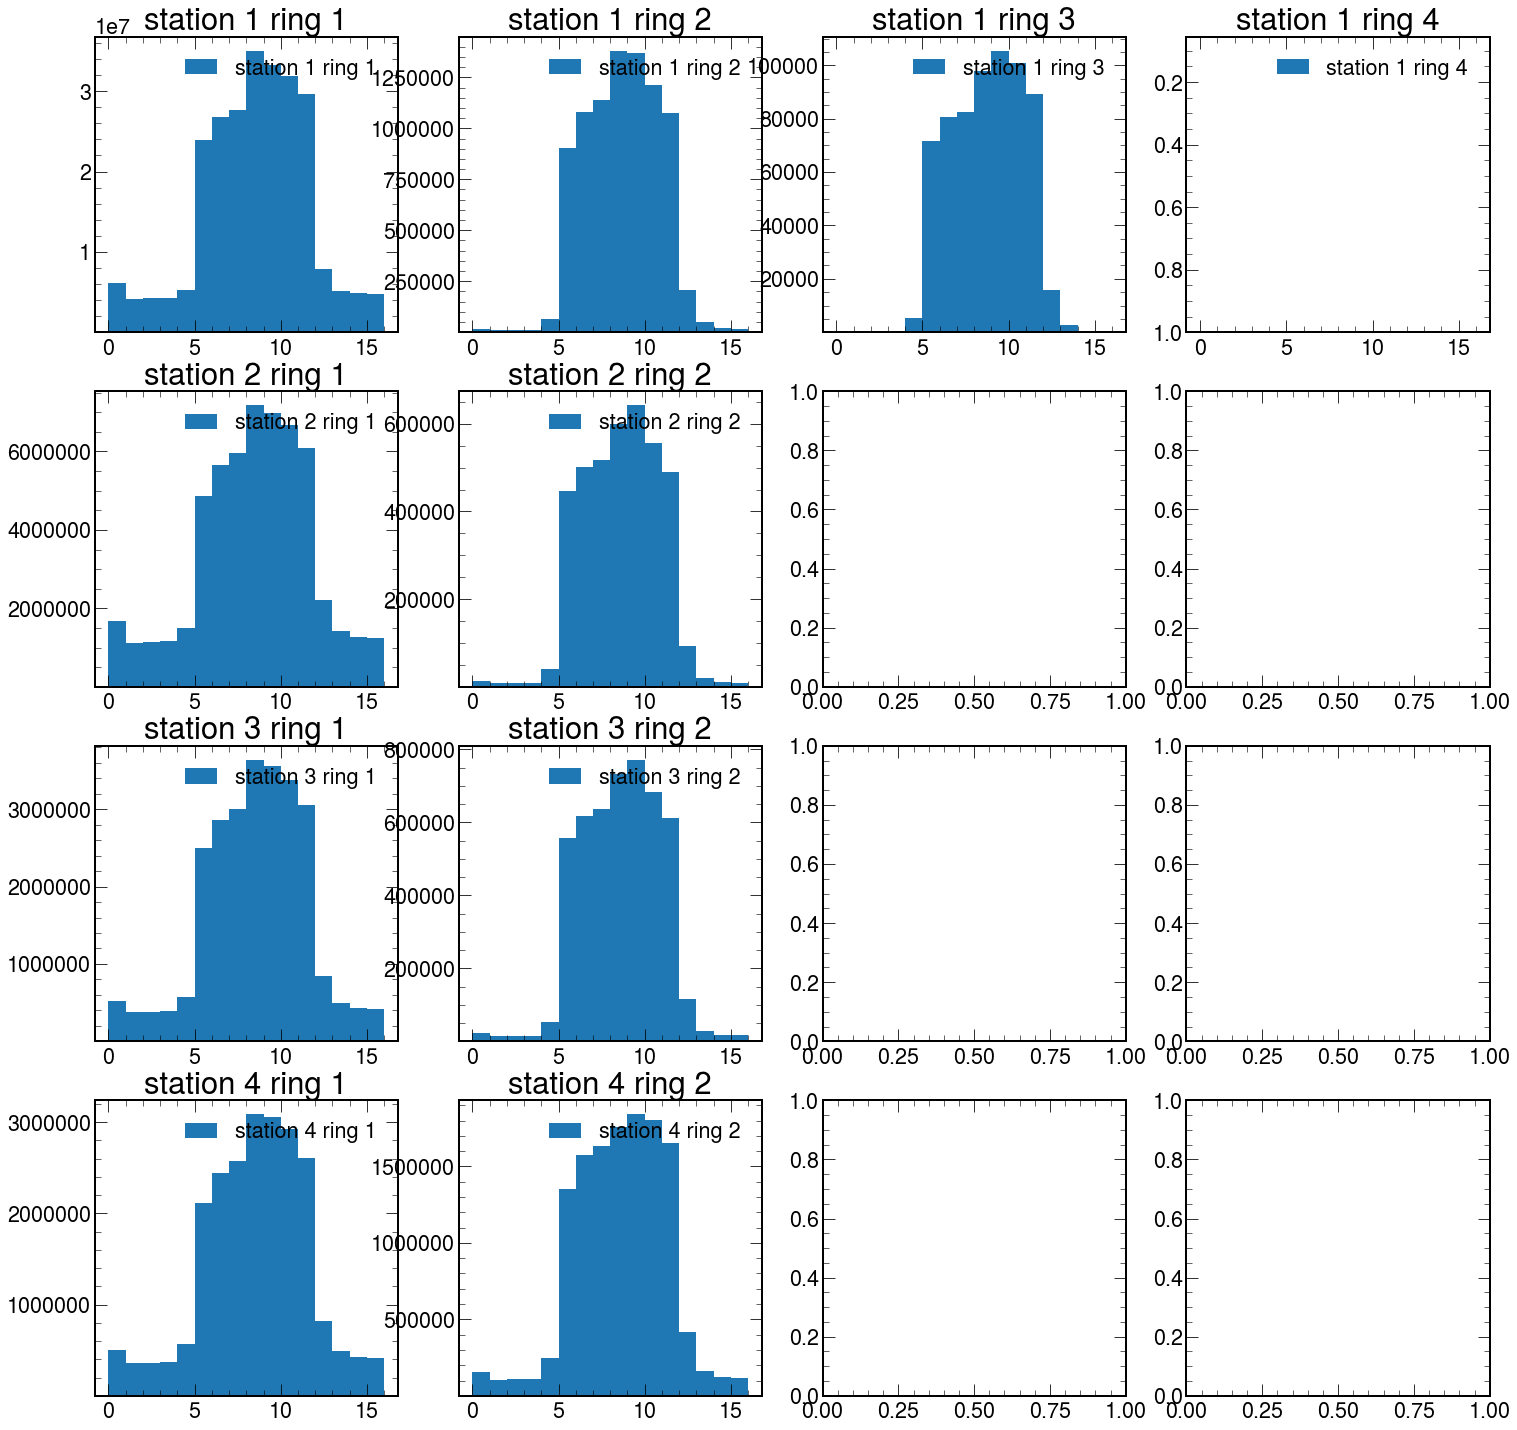

In [164]:
comb_s_r = [(1,1), (1,2), (1,3), (1,4), (2,1), (2,2), (3,1), (3,2), (4,1), (4,2)]

merged_hist_wireTime = [np.sum(np.array(results0)[:,i]) for i in range(len(results0[0]))]

figwt, axswt = plt.subplots(4,4, figsize=(25,25))

[merged_hist_wireTime[i].plot(axswt[comb_s_r[i][0]-1][comb_s_r[i][1]-1]) for i in range(len(comb_s_r))]

#[axswt[comb_s_r[i][0]-1][comb_s_r[i][1]-1].set_yscale('log') for i in range(len(comb_s_r)) ]
[axswt[comb_s_r[i][0]-1][comb_s_r[i][1]-1].set_ylim(bottom=1) for i in range(len(comb_s_r)) ]
[axswt[comb_s_r[i][0]-1][comb_s_r[i][1]-1].set_title("station " + str(comb_s_r[i][0]) + " ring " + str(comb_s_r[i][1])) for i in range(len(comb_s_r))]
plt.savefig("/home/users/hmei/public_html/plotDump/wireTime_20201116.pdf", bbox_inches='tight')

In [66]:
%%time
def gethist(args):
    fname,entrystart,entrystop = args
    try:
        from distributed import get_worker
        worker = get_worker()
        # array cache
        cache = worker.cache
        # also cache the tree object (otherwise opening file+getting tree is ~0.7s overhead)
        if fname in worker.treecache:
            t = worker.treecache[fname]
        else:
            f = uproot4.open(fname)
            t = f["cscRootMaker/Events"]
            worker.treecache[fname] = t
    except:
        cache = None
        f = uproot4.open(fname)
        t = f["cscRootMaker/Events"]
        
    rh_keys = t.keys(filter_name="recHits2D_*")
    rhcoll = t.arrays(rh_keys, library="ak", how="zip") 
    mask_station = [rhcoll.recHits2D.ID_station == i for i in range(1,5)]
    mask_ring = [rhcoll.recHits2D.ID_ring == i for i in range(1,5)]
    comb_s_r = [(1,1), (1,2), (1,3), (1,4), (2,1), (2,2), (3,1), (3,2), (4,1), (4,2)]
    mask_chamberID = [ mask_station[c_[0]-1] & mask_ring[c_[1]-1] for c_ in comb_s_r ]
    
    #mask_belongsToMuon = rhcoll.recHits2D.belongsToMuon
    #bin_btm = np.linspace(-2,2,5)
    #hist_btm = Hist1D(np.array( ak.flatten(mask_belongsToMuon) ), bins=bin_btm)
    ##
    #localYYerr = rhcoll.recHits2D.localYYerr/rhcoll.recHits2D.localY
    #bin_yerr = np.linspace(0,0.1,100)
    #hist_yerr = Hist1D(np.array(ak.flatten(localYYerr) ), bins=bin_yerr)

    #localXXerr = abs(rhcoll.recHits2D.localXXerr)/rhcoll.recHits2D.localX
    localXXerr = rhcoll.recHits2D.localXXerr
    bin_xerr = np.linspace(0,0.01,100)
    hist_xerr = Hist1D(np.array(ak.flatten(localXXerr) ), bins=bin_xerr)
    
    #hitWireTime = rhcoll.recHits2D.wireTime
    #bin_wireTime = np.linspace(0,16,17)
    #hist_hitWireTime = Hist1D(np.array(ak.flatten(hitWireTime)), bins=bin_wireTime)
    
    #mask_yerr = rhcoll.recHits2D.localYYerr < 2
    mask_xerr = rhcoll.recHits2D.localXXerr < 0.01 
    
    localx = [ ak.flatten(rhcoll.recHits2D.localX[mask_]) for mask_ in mask_chamberID]
    localy = [ ak.flatten(rhcoll.recHits2D.localY[mask_]) for mask_ in mask_chamberID]
    hitWireTime = [ ak.flatten(rhcoll.recHits2D.wireTime[mask_]) for mask_ in mask_chamberID]

    bin_localx = np.linspace(-100,100,101)
    bin_localy = np.linspace(-200,200,81)
    hists_localxy = [ Hist2D(np.c_[ak.to_numpy(localx[i]), ak.to_numpy(localy[i])], bins=[bin_localx, bin_localy],
                           label="station " + str(comb_s_r[i][0]) + " ring " + str(comb_s_r[i][1]) ) for i in range(len(comb_s_r)) ]
    
    bin_wireTime = np.linspace(0,16,17)
    hists_wireTime = [ Hist1D(ak.to_numpy(hitWireTime[i]), bins=bin_wireTime,
                           label="station " + str(comb_s_r[i][0]) + " ring " + str(comb_s_r[i][1]) ) for i in range(len(comb_s_r)) ]
    #return hists_localxy
    return hists_localxy, hists_wireTime
    #return hists_localxy, hist_btm, hist_yerr, hist_xerr

index = 15 
x = gethist((chunks[index][0],chunks[index][1],chunks[index][2]//20))
#x,h1,h2,h3 = gethist((chunks[9][0],chunks[9][1],chunks[9][2]//20))

CPU times: user 3.39 s, sys: 490 ms, total: 3.88 s
Wall time: 3.88 s


/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [67]:
x[1][0]

[90983.00 ± 301.63    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
  0.00 ± 0.00    0.00 ± 0.00   15236.00 ± 123.43    0.00 ± 0.00
  0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
  0.00 ± 0.00    0.00 ± 0.00   51740.00 ± 227.46]

In [88]:
## find this event, send to tim
index = 145 
x = gethist((chunks[index][0],chunks[index][1],chunks[index][2]//20))
x[0]

[[ 0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00   ...    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00]
 [ 0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00   ...    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00]
 [ 0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00   ...    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00]
 ...
 [ 0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00   ...    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00]
 [ 0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00   ...    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00]
 [ 0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00   ...    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00]]

In [45]:
import pprint

# Prints the nicely formatted dictionary
processing_items = c.processing()
pprint.pprint(processing_items)

{'tcp://169.228.131.62:35050': (),
 'tcp://169.228.131.94:42999': ('gethist-049bd25d0170066b05c2a845aa12a935',),
 'tcp://169.228.131.94:46675': ('gethist-ed4dfc5c21c31154856e255c47eb3e02',),
 'tcp://169.228.132.107:34733': ('gethist-7542c8b8d2076f2521447a064db63916',),
 'tcp://169.228.132.118:33215': (),
 'tcp://169.228.132.139:36344': ('gethist-be8bf5146af7dce7d22c21e99d74ac39',),
 'tcp://169.228.132.139:39393': ('gethist-b2111ef5ce613e26193804e1178071dc',),
 'tcp://169.228.132.139:40302': ('gethist-375a2df2123615b3a3d58a0c7538b62d',),
 'tcp://169.228.132.139:45673': ('gethist-e621e0090e7b76e7f71b028ccef6a562',),
 'tcp://169.228.132.139:46122': ('gethist-4ac7729c988f7756fef5ab99b73f6d8f',),
 'tcp://169.228.132.139:46734': ('gethist-e60cffa3a3177b7654bc1698e15748af',),
 'tcp://169.228.132.143:36418': ('gethist-b1ba8bd9e664c1504e8af8468f6dd732',),
 'tcp://169.228.132.143:40420': ('gethist-4057fb31d67b7595102b78da08cc3043',),
 'tcp://169.228.132.152:24234': ('gethist-1ed0f7b93175327520a3

In [41]:
for key in processing_items:
    if len(processing_items[key]) == 0: continue
    c.retire_workers(workers=[key])
    #print (key)
    

In [40]:
c.retire_workers(workers=["tcp://169.228.132.104:37991"])hists_localxy

{'tcp://169.228.132.104:37991': {'type': 'Worker',
  'id': 67,
  'host': '169.228.132.104',
  'resources': {},
  'local_directory': '/srv/temp/dask-worker-space/dask-worker-space/worker-xa7olo7l',
  'name': 67,
  'nthreads': 1,
  'memory_limit': 2000000000,
  'last_seen': 1605450555.2428818,
  'services': {'dashboard': 40453},
  'metrics': {'cpu': 2.0,
   'memory': 925032448,
   'time': 1605450555.2419398,
   'read_bytes': 33906914.01945323,
   'write_bytes': 199623.0291664979,
   'num_fds': 27,
   'executing': 0,
   'in_memory': 60,
   'ready': 0,
   'in_flight': 0,
   'bandwidth': {'total': 100000000, 'workers': {}, 'types': {}}},
  'nanny': 'tcp://169.228.132.104:37574'}}

In [12]:
%%time
futures = []
for i in range(len(chunks)):
    if i == 145: continue 
    if chunks[i][2] == 0: continue
    future = c.submit(gethist, chunks[i])#, pure=False)
    futures.append(future)

#futures = c.map(get_hist,chunks[:500])#,pure=False)
#results = c.gather(futures)
#len(results)

CPU times: user 169 ms, sys: 23.9 ms, total: 193 ms
Wall time: 172 ms


In [13]:
progress(futures)

VBox()

In [14]:
results = c.gather(futures)
len(results)

319

In [45]:
results[0][0]

[[ 0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00   ...    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00]
 [ 0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00   ...    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00]
 [ 0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00   ...    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00]
 ...
 [ 0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00   ...    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00]
 [ 0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00   ...    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00]
 [ 0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00   ...    0.00 ± 0.00
   0.00 ± 0.00    0.00 ± 0.00]]

In [56]:
hist_localxy_res = np.array(results)[:,0,:]
hist_wireTime_res = np.array(results)[:,1,:]

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


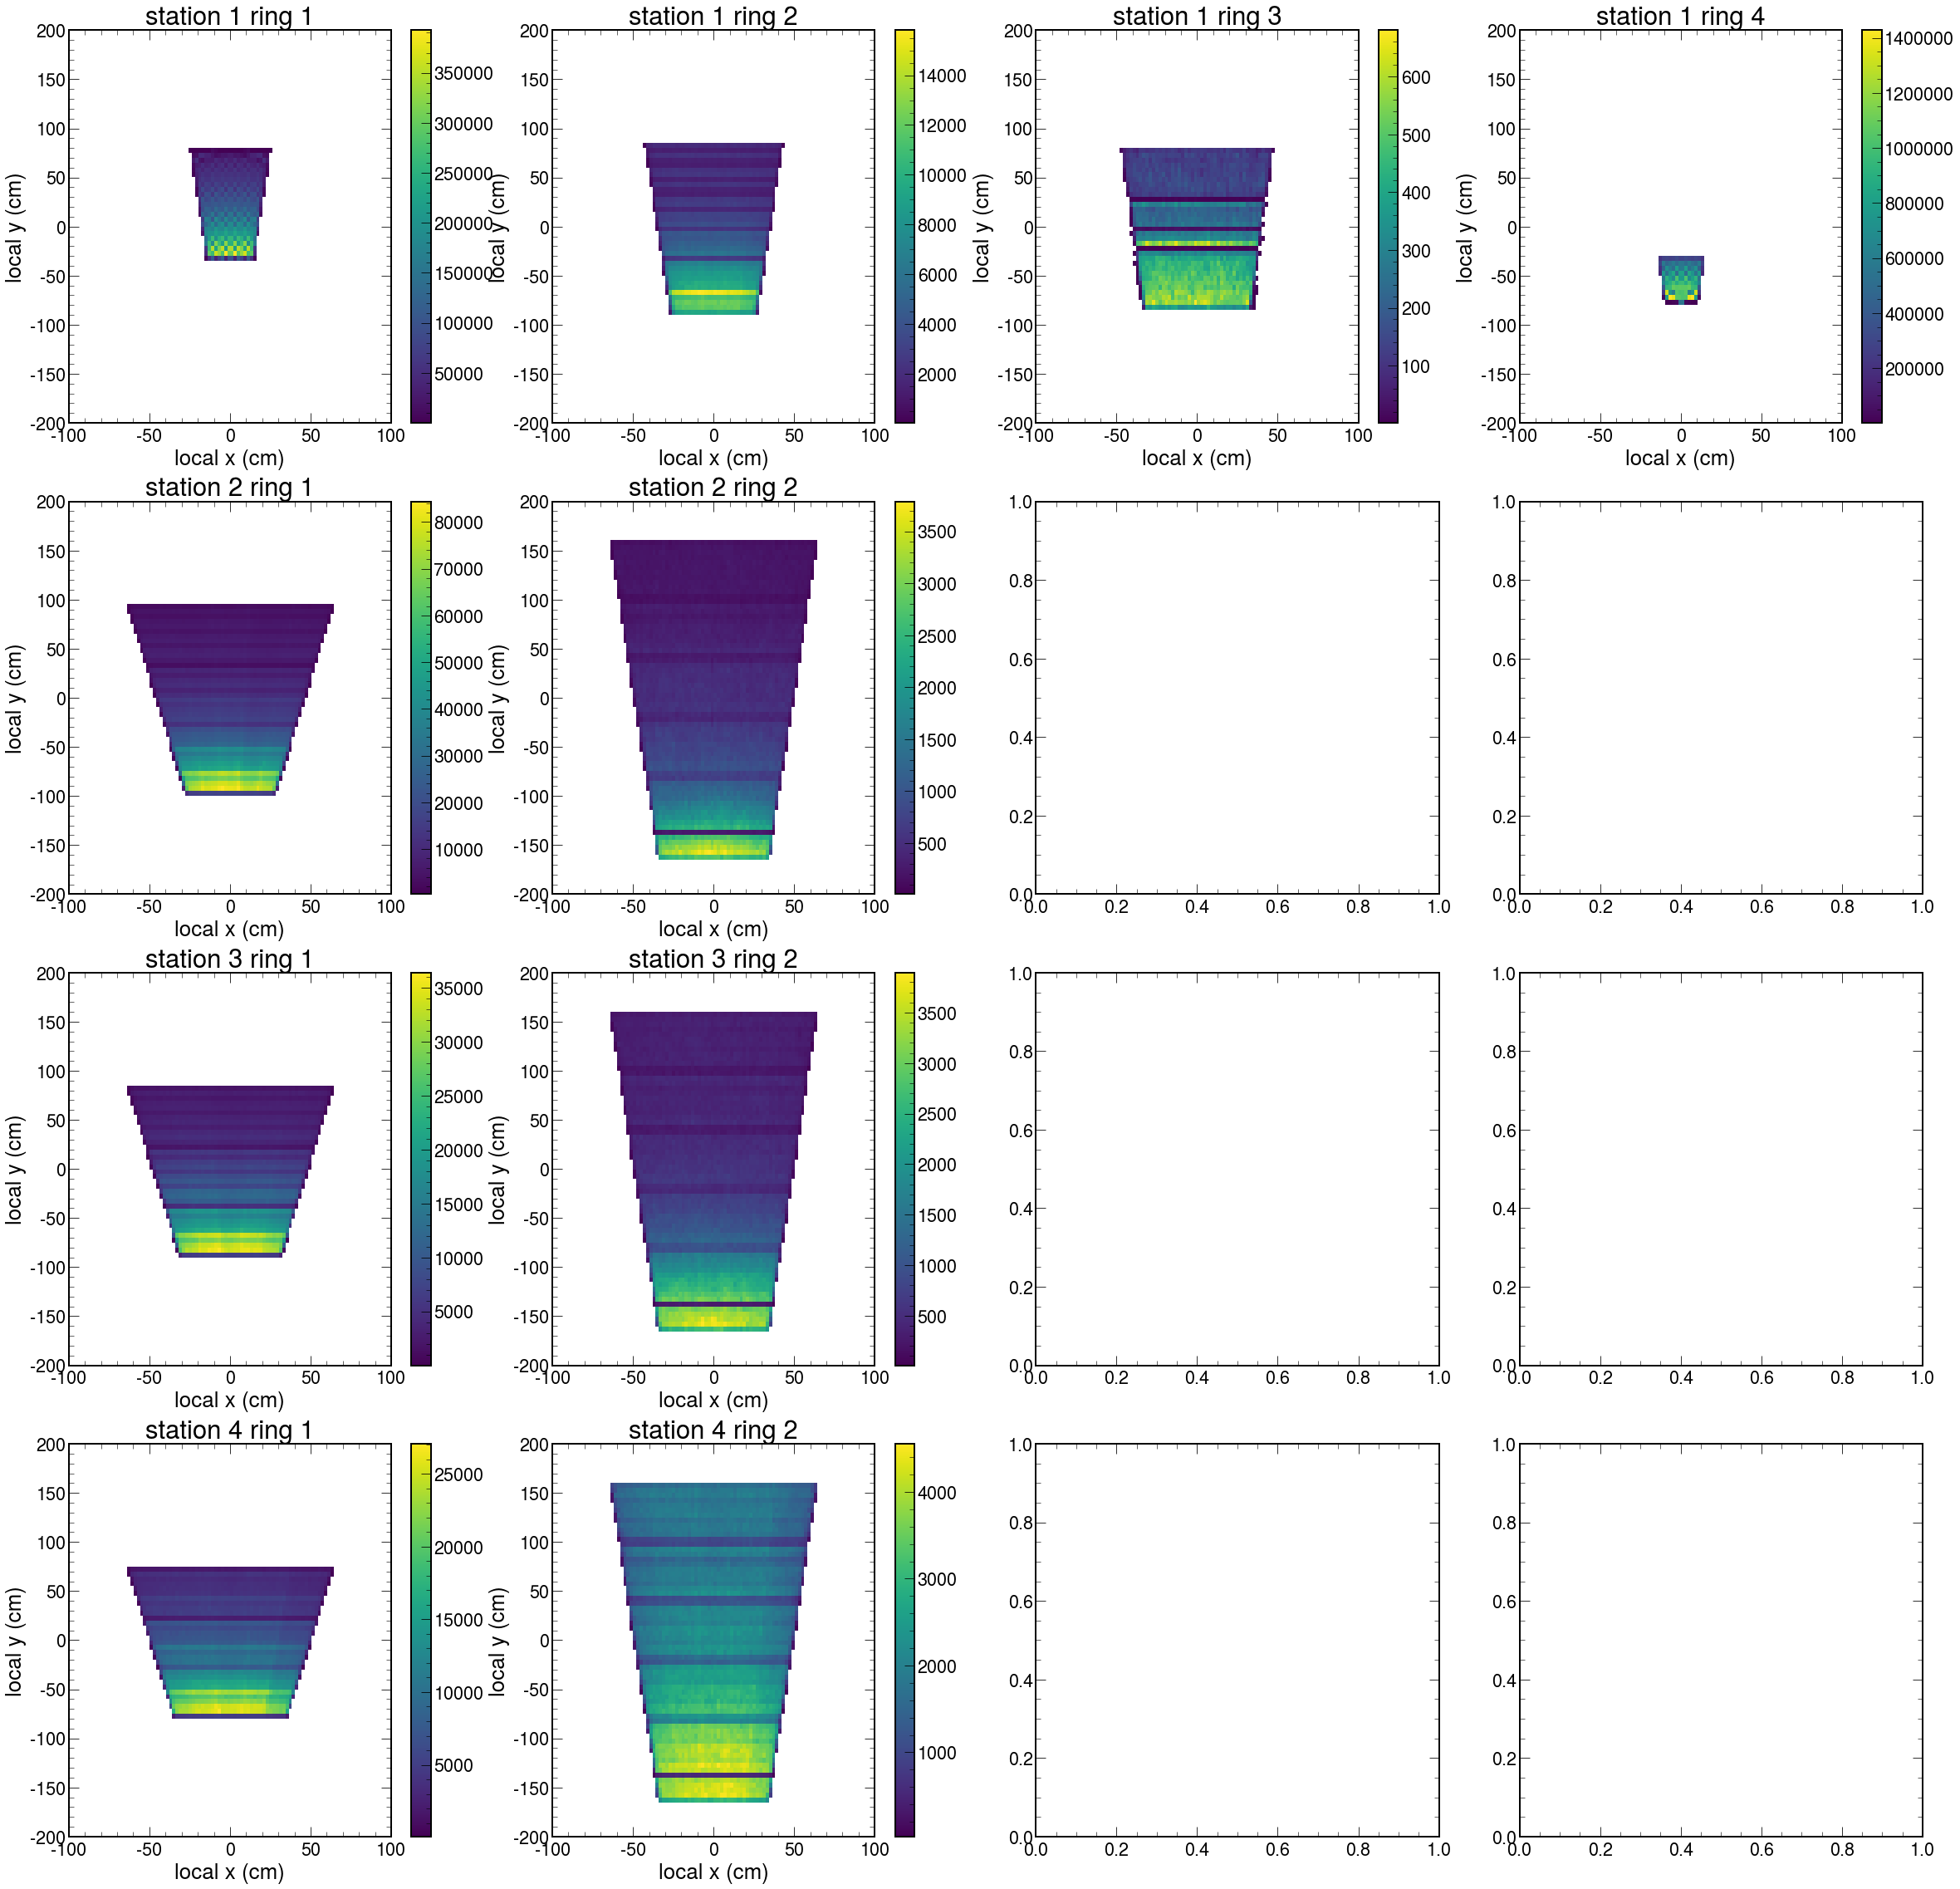

In [154]:
#np.sum( np.array(results)[:,3] )
comb_s_r = [(1,1), (1,2), (1,3), (1,4), (2,1), (2,2), (3,1), (3,2), (4,1), (4,2)]

merged_hist_localxy = [np.sum(np.array(hist_localxy_res)[:,i]) for i in range(len(hist_localxy_res[0]))]

#figxy, axsxy = plt.subplots(4,4, figsize=(25,25))
figxy, axsxy = plt.subplots(4,4, figsize=(40,40))

[merged_hist_localxy[i].plot(axsxy[comb_s_r[i][0]-1][comb_s_r[i][1]-1]) for i in range(len(comb_s_r))]

[axsxy[comb_s_r[i][0]-1][comb_s_r[i][1]-1].set_title("station " + str(comb_s_r[i][0]) + " ring " + str(comb_s_r[i][1])) for i in range(len(comb_s_r))]
[axsxy[comb_s_r[i][0]-1][comb_s_r[i][1]-1].set_xlabel("local x (cm)") for i in range(len(comb_s_r))]
[axsxy[comb_s_r[i][0]-1][comb_s_r[i][1]-1].set_ylabel("local y (cm)") for i in range(len(comb_s_r))]

plt.savefig("/home/users/hmei/public_html/plotDump/CSCHitOccupancy_20201116.pdf", bbox_inches='tight')

[Text(0.5, 1.0, 'station 1 ring 1'),
 Text(0.5, 1.0, 'station 1 ring 2'),
 Text(0.5, 1.0, 'station 1 ring 3'),
 Text(0.5, 1.0, 'station 1 ring 4'),
 Text(0.5, 1.0, 'station 2 ring 1'),
 Text(0.5, 1.0, 'station 2 ring 2'),
 Text(0.5, 1.0, 'station 3 ring 1'),
 Text(0.5, 1.0, 'station 3 ring 2'),
 Text(0.5, 1.0, 'station 4 ring 1'),
 Text(0.5, 1.0, 'station 4 ring 2')]

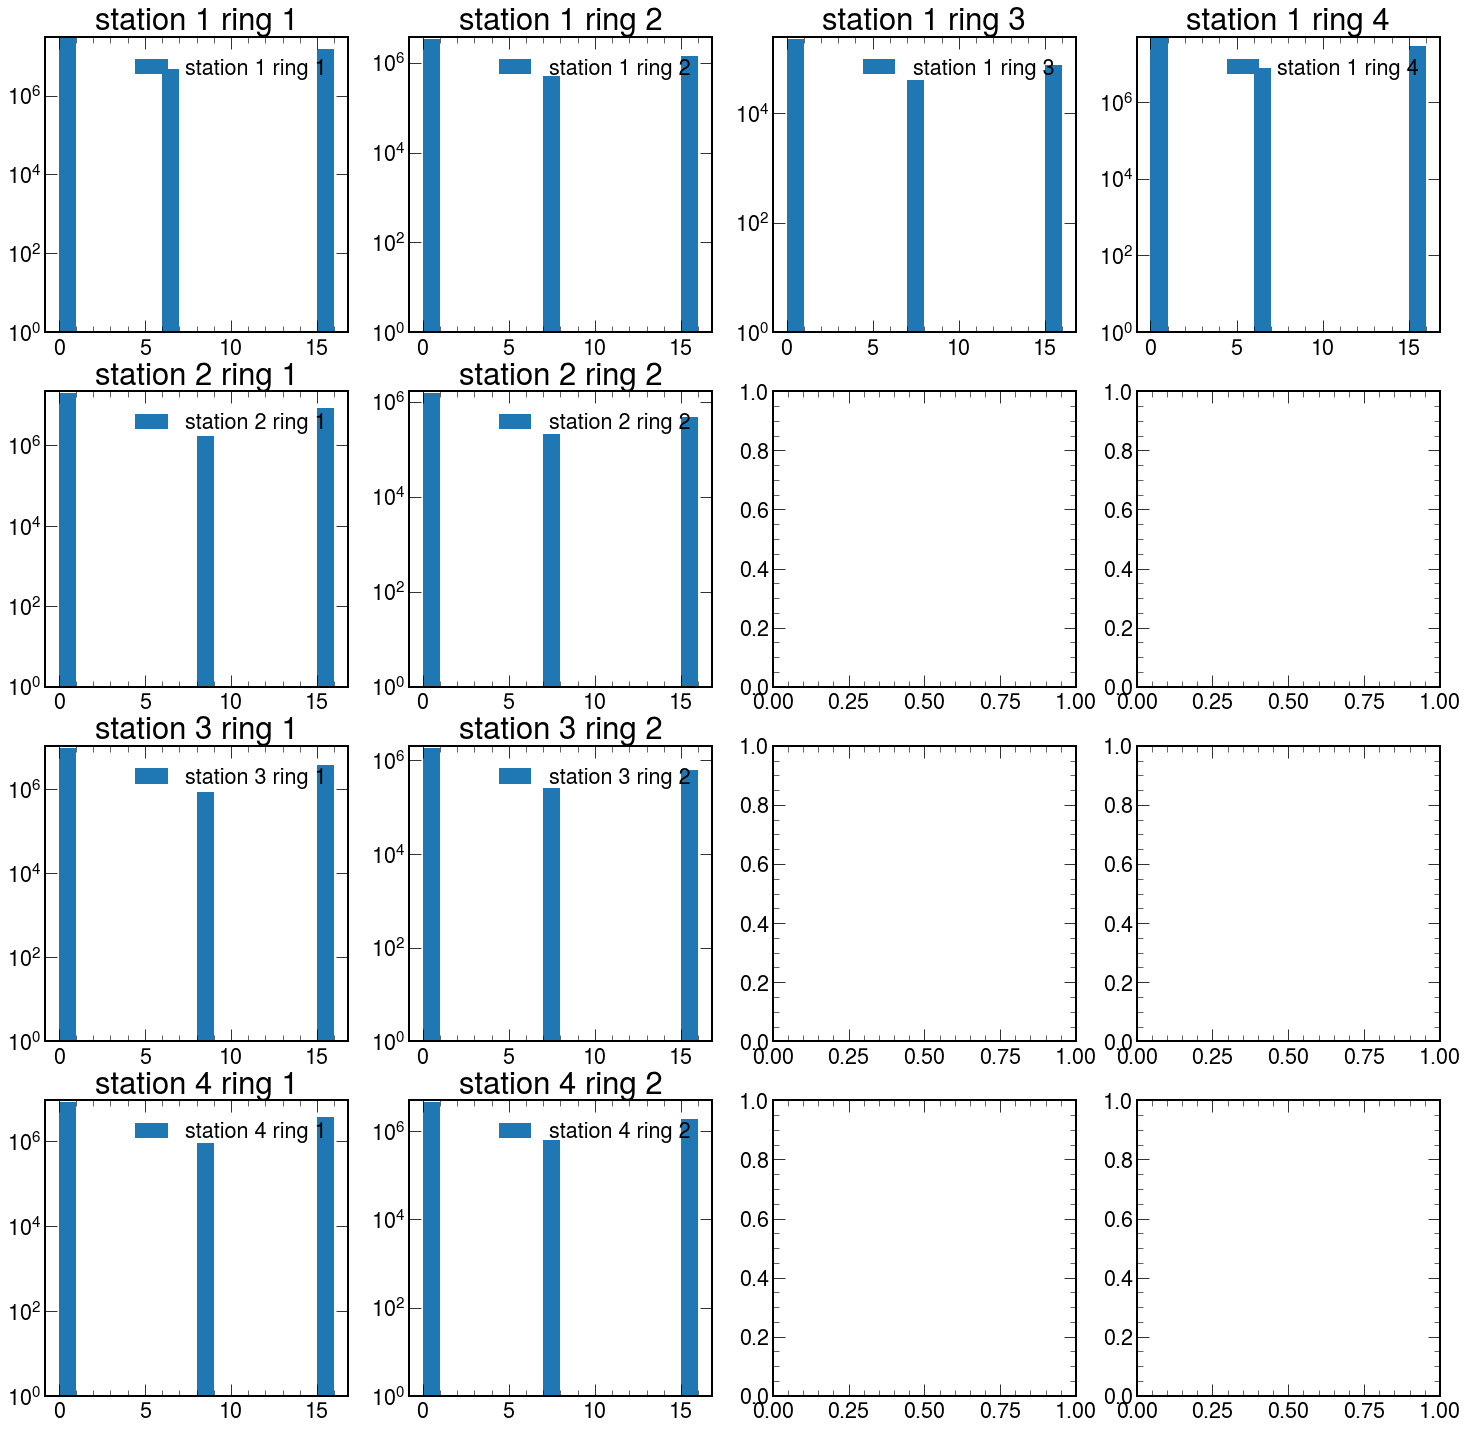

In [65]:
comb_s_r = [(1,1), (1,2), (1,3), (1,4), (2,1), (2,2), (3,1), (3,2), (4,1), (4,2)]

merged_hist_wireTime = [np.sum(np.array(hist_wireTime_res)[:,i]) for i in range(len(hist_wireTime_res[0]))]

figwt, axswt = plt.subplots(4,4, figsize=(25,25))

[merged_hist_wireTime[i].plot(axswt[comb_s_r[i][0]-1][comb_s_r[i][1]-1]) for i in range(len(comb_s_r))]

[axswt[comb_s_r[i][0]-1][comb_s_r[i][1]-1].set_yscale('log') for i in range(len(comb_s_r)) ]
[axswt[comb_s_r[i][0]-1][comb_s_r[i][1]-1].set_ylim(bottom=1) for i in range(len(comb_s_r)) ]
[axswt[comb_s_r[i][0]-1][comb_s_r[i][1]-1].set_title("station " + str(comb_s_r[i][0]) + " ring " + str(comb_s_r[i][1])) for i in range(len(comb_s_r))]

### get effective area of each chamber type

In [12]:
## these area are wrong, see picture above
merged_hist_localxy[0]._counts
areas = [np.count_nonzero(merged_hist_localxy[i]._counts)/8000.0*(200*400) for i in range(len(merged_hist_localxy))]
areas

[4660.0,
 12340.0,
 13550.0,
 1260.0,
 18080.0,
 32280.000000000004,
 16870.0,
 32280.000000000004,
 15500.0,
 32280.000000000004]

### do something in chamber without muon

In [13]:
import numba as nb

In [19]:
@nb.jit
def doCSC(events):
    ''' 
    keys_tosave = ["Event", "Run", "LumiSect", 
                   "muons_cscSegmentRecord_endcap", 
                   "muons_cscSegmentRecord_station",
                   "muons_cscSegmentRecord_ring", 
                   "muons_cscSegmentRecord_chamber",
                   "muons_nMuons"
                  ]
    '''
    
    # get total number of rechits in this tree
    nrh_tot = 0
    for event in events:
        nrh_tot += event.recHits2D_nRecHits2D
        
    # run,evt,lumi,endcap,station,ring,chamber,inCSCHasMu
    cscHasRH = np.zeros((nrh_tot, 8), dtype=np.int64) 
    
    nrh_cnt = np.int64(0)
    
    for event in events:
        evt_id = np.array([event.Run, event.Event, event.LumiSect])
        
        # get number of chambers associated with muons in this event
        nseg_evt = 0
        nmu_evt = len(event.muons_cscSegmentRecord_endcap)
        for i in range(nmu_evt):
            ncscseg = len(event.muons_cscSegmentRecord_endcap[i])
            nseg_evt += ncscseg
            
        # save all csc id with muon segment
        csc_hasMu_evt = np.zeros((nseg_evt,4), dtype=np.int64)
        nseg_evt2 = 0
        for i in range(nmu_evt):
            ncscseg = len(event.muons_cscSegmentRecord_endcap[i])
            if ncscseg <= 0: continue
            for j in range(ncscseg):
                csc_hasMu_evt[nseg_evt2] = np.array([ event.muons_cscSegmentRecord_endcap[i][j],
                                                      event.muons_cscSegmentRecord_station[i][j],
                                                      event.muons_cscSegmentRecord_ring[i][j],
                                                      event.muons_cscSegmentRecord_chamber[i][j] ])
                nseg_evt2 += 1
            
        rechits = event.recHits2D
        for rh in rechits: 
            csc_id = np.array([rh.ID_endcap, rh.ID_station, rh.ID_ring, rh.ID_chamber])
            evt_csc_id = np.append(evt_id, csc_id)
            csc_found = False 
            # check if this csc has muon
            for csc_id_mu in csc_hasMu_evt:
                if np.array_equal(csc_id, csc_id_mu):
                    csc_found = True
                    break
            cscHasRH[nrh_cnt] = np.append(evt_csc_id, np.array([np.int64(csc_found)])) 
            nrh_cnt += 1
            
    return cscHasRH


### get lumi

In [7]:
#import csv
df_lumi = pd.read_csv("/hadoop/cms/store/user/hmei/lumi/output_byls_2018ABCD_hzub_clean.csv") 

### do all csc

In [56]:
%%time
lumifile = "/hadoop/cms/store/user/hmei/lumi/output_byls_2018ABCD_hzub.csv"
def getLumi(run, lumisect, lumifile):
    import subprocess
    #grep 315252 /hadoop/cms/store/user/hmei/lumi/output_byls_2018ABCD_hzub.csv | grep ",5:" | awk -F "," '{print $7}'
    #command = " grep \"" + str(run) + ":\" " + lumifile + "| grep \"," + str(lumisect) + ":\" | awk -F \",\" '{print $7}' "
    command = " grep " + str(run) + " "  + lumifile + "| grep \"," + str(lumisect)+ ":\" | awk -F \",\" '{print $7}' "
    tmpLumi = (subprocess.Popen(command,stdout=subprocess.PIPE,shell=True) ).communicate()[0]
    lumi = tmpLumi.decode("utf-8").strip('\n')
    return lumi


getLumi(315252, 5, lumifile)

CPU times: user 54.3 ms, sys: 38.7 ms, total: 93 ms
Wall time: 456 ms


'4361.948024352'

In [92]:
%%time
def doCSCAll(args):
    
    df_lumi_path = "/hadoop/cms/store/user/hmei/lumi/output_byls_2018ABCD_hzub_clean.csv"
    
    fname,entrystart,entrystop = args
    try:
        from distributed import get_worker
        worker = get_worker()
        # array cache
        cache = worker.cache
        # also cache the tree object (otherwise opening file+getting tree is ~0.7s overhead)
        if fname in worker.treecache:
            t = worker.treecache[fname]
        else:
            f = uproot4.open(fname)
            t = f["cscRootMaker/Events"]
            worker.treecache[fname] = t
    except:
        cache = None
        f = uproot4.open(fname)
        t = f["cscRootMaker/Events"]
    #f = uproot4.open(fname)
    #t = f["cscRootMaker/Events"]
        
    nmuon = t.arrays("muons_nMuons", library="ak", how="zip",entry_start=entrystart, entry_stop=entrystop)
    #nmuon = t.arrays("muons_nMuons", library="ak", how="zip")
    if (ak.sum(nmuon) <= 0):
        # in some root files, there is one event with no muon, which gives problem when using ak, probably due to the muon_cscSegmentRecord...
        #return np.zeros((len(nmuon), 8), dtype=np.int64) 
        return 0 #np.zeros((len(nmuon), 8), dtype=np.int64) 
        
    
    keys_tosave = ["Event", "Run", "LumiSect"]
    events = t.arrays( keys_tosave + t.keys(filter_name="recHits2D_*") + t.keys(filter_name="muons_*"),
                       entry_start=entrystart, entry_stop=entrystop, library="ak", how="zip")
    #events = t.arrays( keys_tosave + t.keys(filter_name="recHits2D_*") + t.keys(filter_name="muons_*"),
    #                   library="ak", how="zip")
    ## get nevts with muon/without muon
    #mask_noMuon = (events.muons_nMuons == 0)
    #nevts = len(events)
    #nevts_noMuon = len(events[mask_noMuon])
    #print ("nEvts total: ", nevts, ", nEvts without muon: ", nevts_noMuon)

    ## get nevts with/without muon-csc segment
    ## mask_muCSCSeg = (events.muons.numberOfSegments > 0)
    ## need to use this instead of numberOfSegments is due to a bug in ntuplizer 
    ## if there is no csc mu segment, numberOfSegments will inherit last event
    museg_endcap = events.muons_cscSegmentRecord_endcap
    mask_noMuCSCSeg = ak.sum( ak.sum(museg_endcap, axis=2) , axis=1) == 0
    #nmucscseg = ak.num(events.muons[mask_muCSCSeg])
    evts_noMuCSCSeg = events[mask_noMuCSCSeg]
    #unique_elements, counts_elements = np.unique(ak.to_numpy(nmucscseg), return_counts=True)
    ##print ("nmucscseg in evt", unique_elements)
    #float_formatter = "{:.2f}".format
    #np.set_printoptions(formatter={'float_kind':float_formatter})
    #print ("fraction of evt", counts_elements/nevts*100 )
    
    ncsc_per_type = {"1_1": 36, "1_2": 36, "1_3": 36, "1_4": 36,
                     "2_1": 18, "3_1": 18, "4_1": 18,
                     "2_2": 36, "3_2": 36, "4_2": 36}
    
    masks_endcap = [evts_noMuCSCSeg.recHits2D.ID_endcap == i for i in range(1,3)]
    masks_station = [evts_noMuCSCSeg.recHits2D.ID_station == i for i in range(1,5)]
    masks_ring = [evts_noMuCSCSeg.recHits2D.ID_ring == i for i in range(1,5)]
    masks_chamber = [evts_noMuCSCSeg.recHits2D.ID_chamber == i for i in range(1,37)]
   
    mask_wireTime1 = [ (evts_noMuCSCSeg.recHits2D.wireTime > 3) & (evts_noMuCSCSeg.recHits2D.wireTime < 6)]
    mask_wireTime2 = [ (evts_noMuCSCSeg.recHits2D.wireTime > 10) & (evts_noMuCSCSeg.recHits2D.wireTime < 14)]
    # get all cscID (e,s,r,c) combination
    cscID_comb = []
    for endcap in range(1,3):
        for station in range(1,5):
            for ring in range(1,5):
                if station > 1 and ring > 2: continue
                for chamber in range(1, ncsc_per_type[str(station) + "_" + str(ring)]+1):
                                     cscID_comb.append((endcap, station, ring, chamber))

    masks_cscID = [ (mask_wireTime1 | mask_wireTime2) & 
                    masks_endcap[c_[0]-1] & masks_station[c_[1]-1] & masks_ring[c_[2]-1] & masks_chamber[c_[3]-1] for c_ in cscID_comb]
    
    # 
    
    df_lumi = pd.read_csv(df_lumi_path) 
    evt_runs = evts_noMuCSCSeg.Run
    evt_lumisects = evts_noMuCSCSeg.LumiSect
    lumi = [df_lumi.loc[ (df_lumi["run"] == evt_runs[i]) & 
                         (df_lumi["lumisect"] == evt_lumisects[i] ) ]["deliver"].to_numpy()
            for i in range(len(evts_noMuCSCSeg))]
    ## this is protect against missing lumi in json file
    ## 1000 is to change to 1e33
    lumi_array = np.array([l[0]/1000.0 if len(l) == 1 else -1 for l in lumi])
    #print (lumi_array)
    evts_noMuCSCSeg.InstLumi = ak.Array(lumi_array)
    
    ## free up some memory
    del df_lumi
    
    rhs_per_csc = evts_noMuCSCSeg.recHits2D
    # per-event, per-cscID
    nrhs_allCSC = [ ak.num( rhs_per_csc[mask] ) for mask in masks_cscID ]
    lumi_allCSC = [ evts_noMuCSCSeg.InstLumi for mask in masks_cscID]
    
    nrh_clean = [ ak.to_numpy(nrhs_allCSC[i][nrhs_allCSC[i] > 0]) for i in range(len(nrhs_allCSC))] 
    lumi_clean = [ ak.to_numpy(lumi_allCSC[i][nrhs_allCSC[i] > 0]) for i in range(len(nrhs_allCSC))] 
    #print (nrh_vs_lumi)
    
    #bin_nrh = np.linspace(0,50,51)
    #bin_lumi = np.linspace(0,25,26)
 #
    #hists_nrh_lumi = [ Hist2D(np.c_[lumi_clean[i], nrh_clean[i]], bins=[bin_lumi, bin_nrh]) for i in range(len(cscID_comb))]
    #hists_nrh_lumi = []
    #return hists_nrh_lumi
    return nrh_clean, lumi_clean

index = 19 
#allHists = doCSCAll((chunks[index][0],chunks[index][1],chunks[index][2]))
rh,lumi = doCSCAll((chunks[index][0],chunks[index][1],chunks[index][2]))
#for i in range(19,20):
#    print (i)
#    allHists = doCSCAll((chunks[i][0],chunks[i][1],chunks[i]//20))

CPU times: user 1min 15s, sys: 2.12 s, total: 1min 17s
Wall time: 1min 15s


In [93]:
%%time
lumi_path="/hadoop/cms/store/user/hmei/lumi/output_byls_2018ABCD_hzub_clean.csv"
futures = []
for chunk in chunks:
    if int(chunk[2]) < 1e4: continue
    future = c.submit(doCSCAll, chunk)#, pure=False)
    futures.append(future)

#results = c.gather(futures)
#len(results)


CPU times: user 332 ms, sys: 57.2 ms, total: 389 ms
Wall time: 333 ms


In [94]:
from dask.distributed import progress

progress(futures)

VBox()

In [95]:
c.retire_workers(workers=["tcp://169.228.132.107:44524"])

{'tcp://169.228.132.107:44524': {'type': 'Worker',
  'id': 45,
  'host': '169.228.132.107',
  'resources': {},
  'local_directory': '/srv/temp/dask-worker-space/dask-worker-space/worker-erbcpy_3',
  'name': 45,
  'nthreads': 1,
  'memory_limit': 2000000000,
  'last_seen': 1605281677.099605,
  'services': {'dashboard': 41820},
  'metrics': {'cpu': 6.8,
   'memory': 1292693504,
   'time': 1605281677.0999248,
   'read_bytes': 2250575.394378403,
   'write_bytes': 706126.9272620969,
   'num_fds': 32,
   'executing': 1,
   'in_memory': 6,
   'ready': 1,
   'in_flight': 0,
   'bandwidth': {'total': 100000000, 'workers': {}, 'types': {}}},
  'nanny': 'tcp://169.228.132.107:36401'}}

In [ ]:
%%time
results = c.gather(futures)

In [97]:
len(results)

271

In [129]:
results[3][0][0]

array([ 5,  6,  4,  9,  6,  5,  4,  6,  5,  5,  4,  5,  4,  9,  4,  8,  5,
       21,  8,  4,  4,  4,  4,  5,  5,  5,  4,  5,  6,  5,  6,  6,  4,  4,
        6,  6,  6,  8, 10, 13,  5,  6,  5,  5,  6,  5,  4,  9,  4, 14, 12,
       69,  8,  7,  5,  6,  5,  4,  7,  7,  6,  5,  9, 14,  5,  5,  5, 11,
        5,  3,  5,  6,  5, 25,  5,  5,  5,  9,  5,  5,  5,  7,  6,  5,  5,
        5,  4,  5,  5,  5,  7, 23,  5, 14,  6,  5,  5,  5,  8,  5,  5,  5,
        3,  9,  5,  6,  9,  5,  5,  6,  4,  6,  7,  4,  6,  7, 17,  5,  5,
        6,  5,  4,  4, 10,  4,  5,  5,  4,  5,  5,  6, 14,  6,  5,  5,  8,
        5,  9,  5,  4,  6,  4,  4,  5,  5,  5,  5,  5,  4,  6,  5, 15, 18,
        5])

In [134]:
comb_s_r = [(1,1), (1,2), (1,3), (1,4), (2,1), (2,2), (3,1), (3,2), (4,1), (4,2)]
comb_s_r.index((1,2))

1

In [160]:
%%time
from datetime import datetime
datetime.now(tz=None)

ncsc_per_type = {"1_1": 36, "1_2": 36, "1_3": 36, "1_4": 36,
                 "2_1": 18, "3_1": 18, "4_1": 18,
                 "2_2": 36, "3_2": 36, "4_2": 36}

comb_s_r = [(1,1), (1,2), (1,3), (1,4), (2,1), (2,2), (3,1), (3,2), (4,1), (4,2)]
nType = len(comb_s_r)
## should turn these two into hist directly

bin_nrh = np.linspace(0,50,51)
bin_lumi = np.linspace(0,25,26)
hists_nrh_lumi = [ Hist2D(np.c_[np.array([]), np.array([])], bins=[bin_lumi, bin_nrh]) for i in range(len(ncsc_per_type))]
hists_nrh = [ Hist1D(np.array([]), bins=bin_nrh) for i in range(len(ncsc_per_type))]

outter_counter = 0
for result in results:
    outter_counter += 1
    dateTimeObj = datetime.now()
    print (outter_counter, dateTimeObj)
    counter = 0
    for endcap in range(1,3):
        for station in range(1,5):
            for ring in range(1,5):
                if station > 1 and ring > 2: continue
                for chamber in range(1, ncsc_per_type[str(station) + "_" + str(ring)]+1):
                    rh = result[0][counter]
                    lumi = result[1][counter]
                    index = comb_s_r.index((station, ring))
                    hists_nrh_lumi[index] += Hist2D(np.c_[lumi,rh], bins=[bin_lumi, bin_nrh])
                    hists_nrh[index] += Hist1D(rh, bins=bin_nrh)
                    counter += 1 

1 2020-11-13 11:07:35.583993
2 2020-11-13 11:07:36.517910
3 2020-11-13 11:07:37.450460
4 2020-11-13 11:07:38.397455
5 2020-11-13 11:07:39.420282
6 2020-11-13 11:07:40.422921
7 2020-11-13 11:07:41.363767
8 2020-11-13 11:07:42.294385
9 2020-11-13 11:07:43.196059
10 2020-11-13 11:07:44.112098
11 2020-11-13 11:07:45.040407
12 2020-11-13 11:07:45.980914
13 2020-11-13 11:07:46.992690
14 2020-11-13 11:07:47.927664
15 2020-11-13 11:07:48.891669
16 2020-11-13 11:07:49.808397
17 2020-11-13 11:07:50.748682
18 2020-11-13 11:07:51.745648
19 2020-11-13 11:07:52.674074
20 2020-11-13 11:07:53.587579
21 2020-11-13 11:07:54.539926
22 2020-11-13 11:07:55.468084
23 2020-11-13 11:07:56.406337
24 2020-11-13 11:07:57.302684
25 2020-11-13 11:07:58.215867
26 2020-11-13 11:07:59.145656
27 2020-11-13 11:08:00.078922
28 2020-11-13 11:08:01.071320
29 2020-11-13 11:08:01.998979
30 2020-11-13 11:08:02.942405
31 2020-11-13 11:08:03.871519
32 2020-11-13 11:08:04.882048
33 2020-11-13 11:08:05.889097
34 2020-11-13 11:08

In [157]:
[np.sum(hists_nrh_lumi[i].counts) for i in range(len(comb_s_r))]

[4450599.0,
 433998.0,
 34923.0,
 7484242.0,
 1460753.0,
 189159.0,
 587382.0,
 225886.0,
 484032.0,
 586450.0]

[Text(0.5, 1.0, 'station 1 ring 1'),
 Text(0.5, 1.0, 'station 1 ring 2'),
 Text(0.5, 1.0, 'station 1 ring 3'),
 Text(0.5, 1.0, 'station 1 ring 4'),
 Text(0.5, 1.0, 'station 2 ring 1'),
 Text(0.5, 1.0, 'station 2 ring 2'),
 Text(0.5, 1.0, 'station 3 ring 1'),
 Text(0.5, 1.0, 'station 3 ring 2'),
 Text(0.5, 1.0, 'station 4 ring 1'),
 Text(0.5, 1.0, 'station 4 ring 2')]

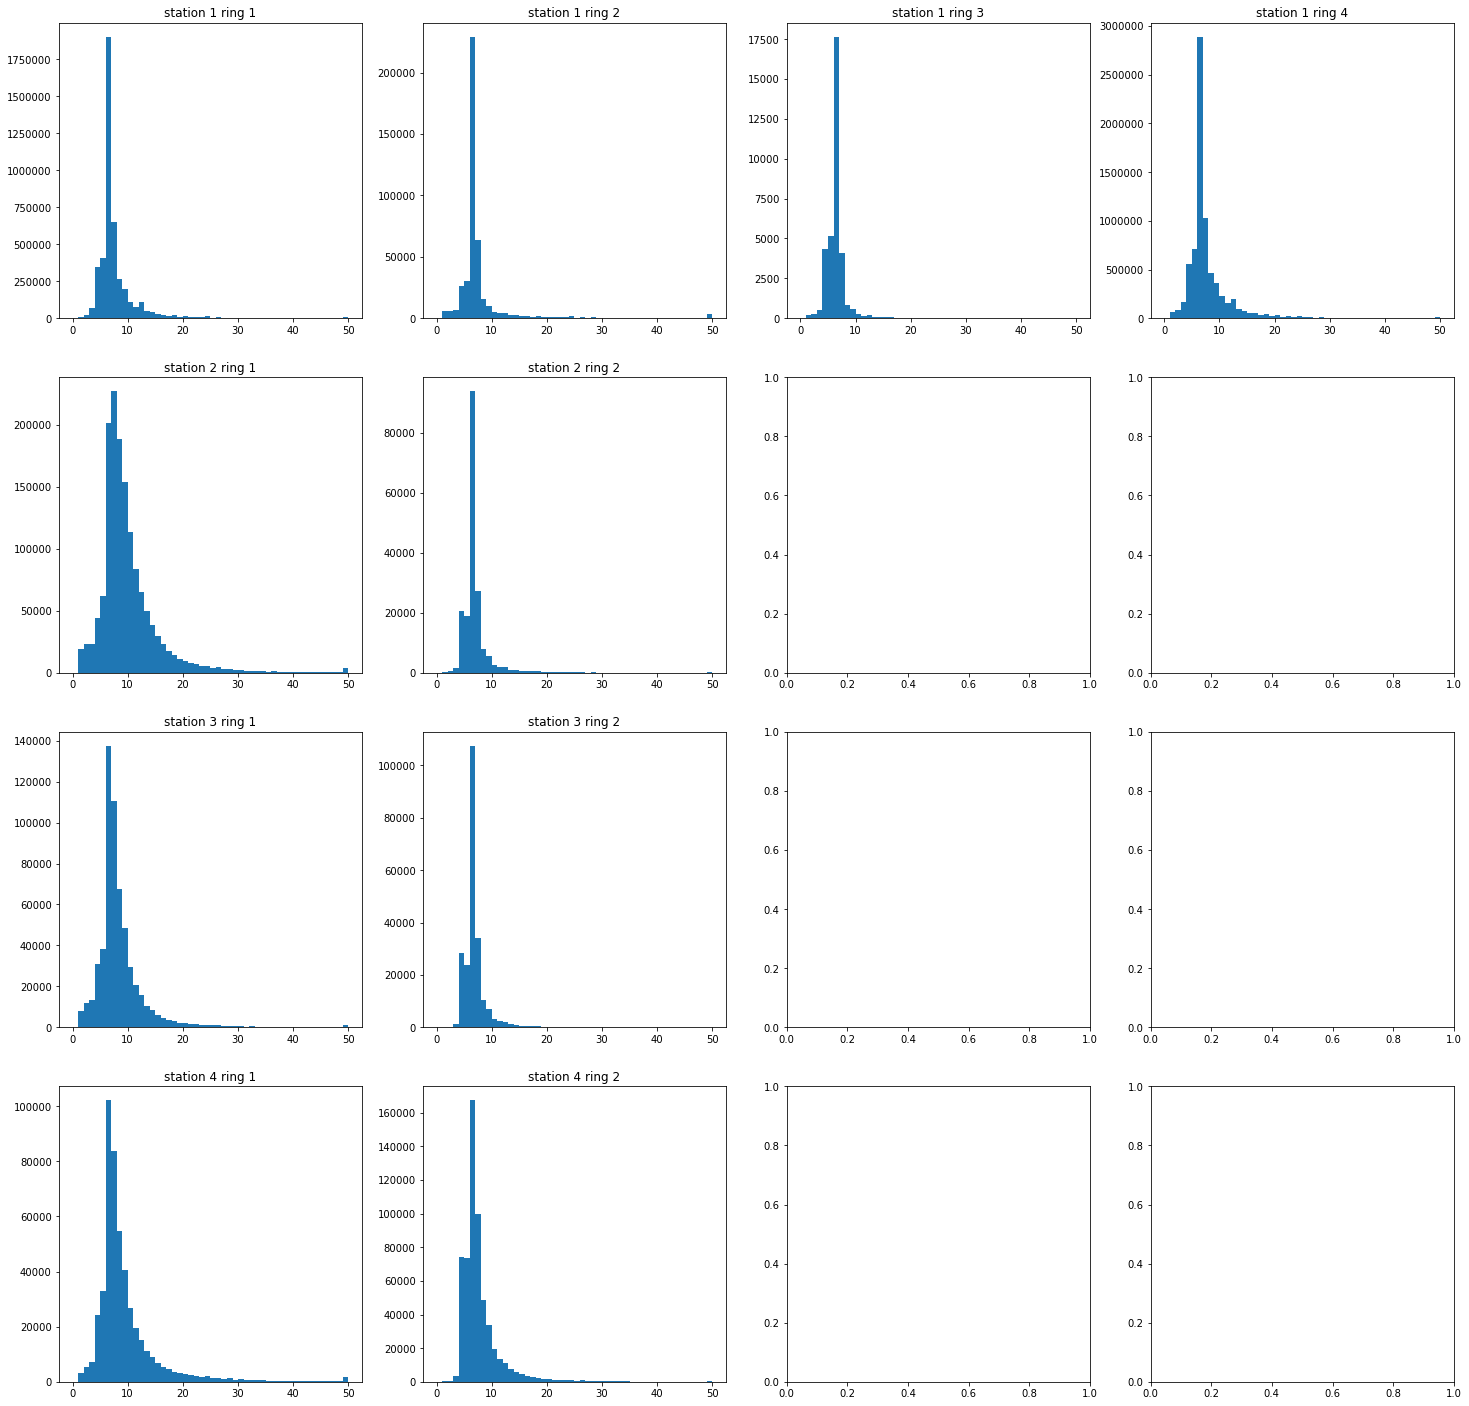

In [163]:
figrh, axsrh = plt.subplots(4,4, figsize=(25,25))

#[hists_nrh_lumi[i].profile("x").plot(axsrhlumi[comb_s_r[i][0]-1][comb_s_r[i][1]-1],show_counts=True,show_errors=True) for i in range(len(comb_s_r))]
[hists_nrh[i].plot(axsrh[comb_s_r[i][0]-1][comb_s_r[i][1]-1]) for i in range(len(comb_s_r))]

[axsrh[comb_s_r[i][0]-1][comb_s_r[i][1]-1].set_title("station " + str(comb_s_r[i][0]) + " ring " + str(comb_s_r[i][1])) for i in range(len(comb_s_r))]

[Text(0.5, 1.0, 'station 1 ring 1'),
 Text(0.5, 1.0, 'station 1 ring 2'),
 Text(0.5, 1.0, 'station 1 ring 3'),
 Text(0.5, 1.0, 'station 1 ring 4'),
 Text(0.5, 1.0, 'station 2 ring 1'),
 Text(0.5, 1.0, 'station 2 ring 2'),
 Text(0.5, 1.0, 'station 3 ring 1'),
 Text(0.5, 1.0, 'station 3 ring 2'),
 Text(0.5, 1.0, 'station 4 ring 1'),
 Text(0.5, 1.0, 'station 4 ring 2')]

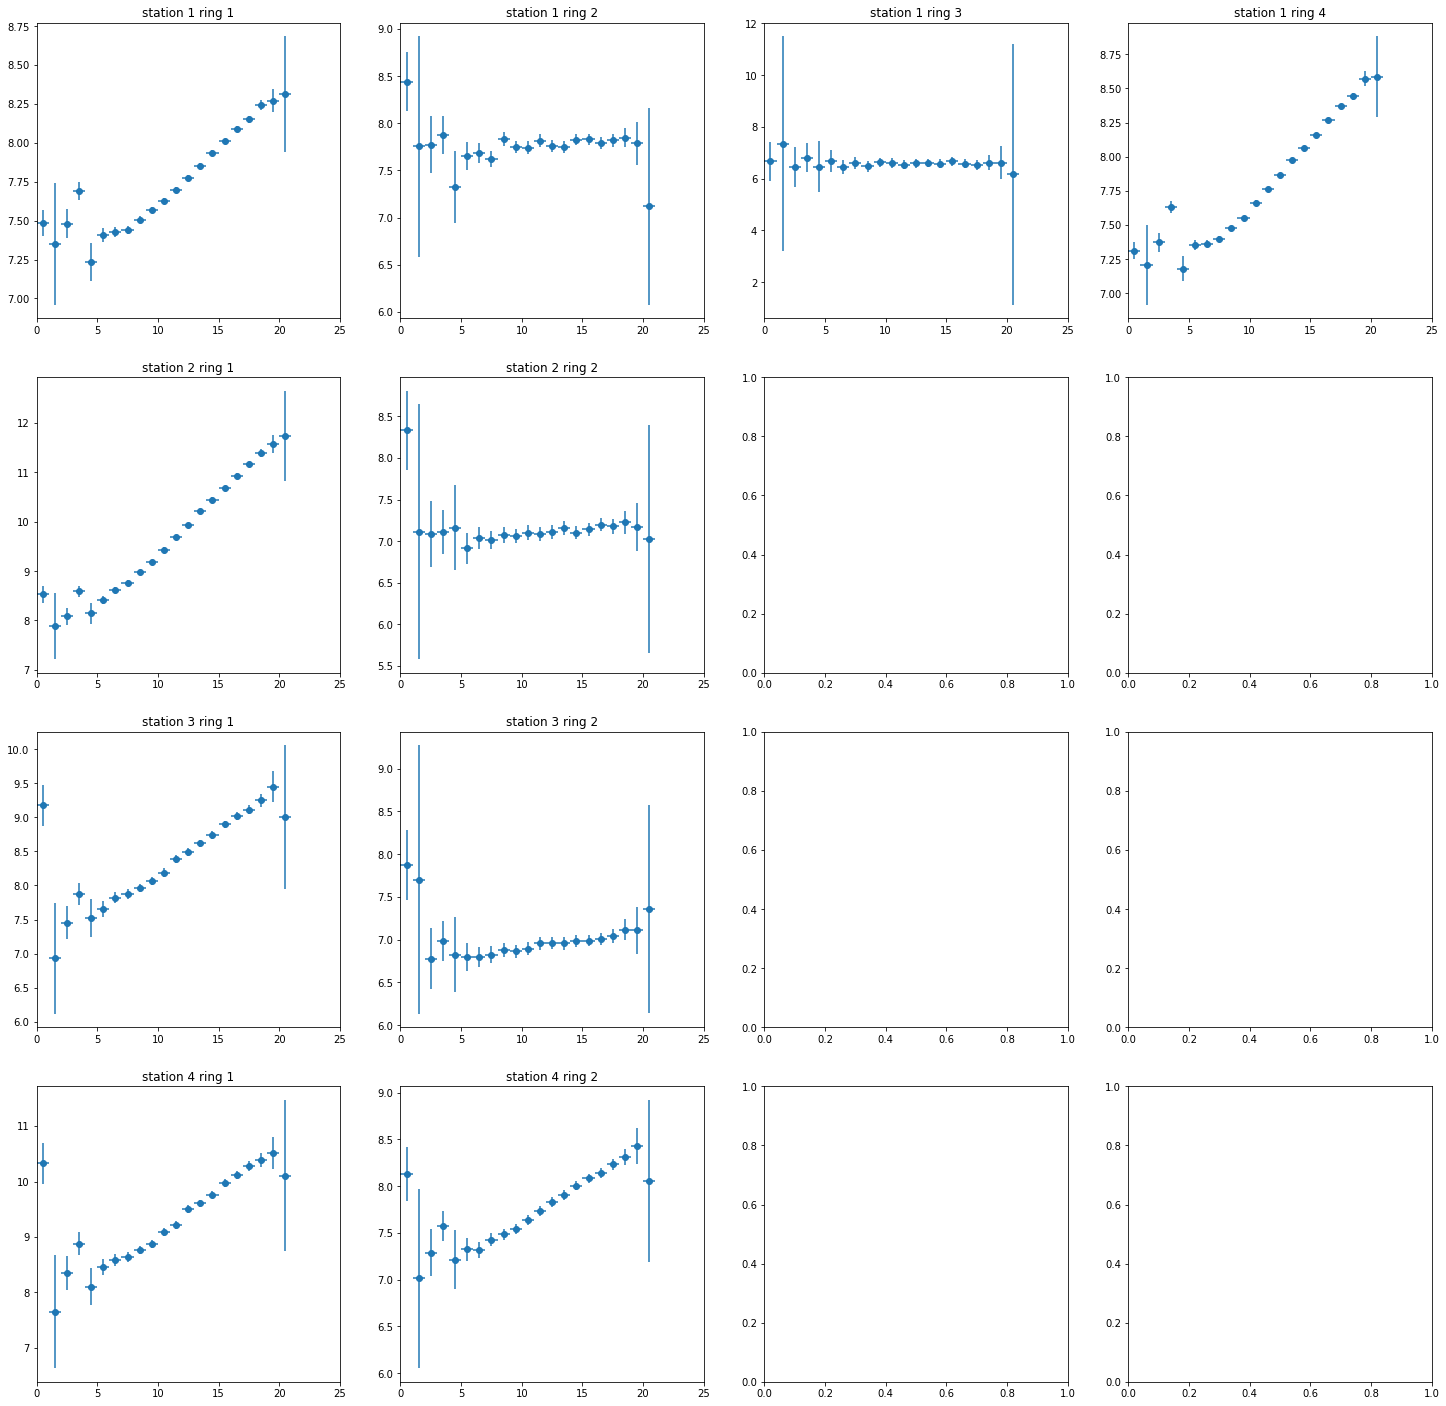

In [158]:
figrhlumi, axsrhlumi = plt.subplots(4,4, figsize=(25,25))

#[hists_nrh_lumi[i].profile("x").plot(axsrhlumi[comb_s_r[i][0]-1][comb_s_r[i][1]-1],show_counts=True,show_errors=True) for i in range(len(comb_s_r))]
[hists_nrh_lumi[i].profile("x").plot(axsrhlumi[comb_s_r[i][0]-1][comb_s_r[i][1]-1],show_errors=True) for i in range(len(comb_s_r))]

[axsrhlumi[comb_s_r[i][0]-1][comb_s_r[i][1]-1].set_title("station " + str(comb_s_r[i][0]) + " ring " + str(comb_s_r[i][1])) for i in range(len(comb_s_r))]

### try wire hit instead of rechit

In [82]:
%%time
def doCSCAll_wire(args):
    
    df_lumi_path = "/hadoop/cms/store/user/hmei/lumi/output_byls_2018ABCD_hzub_clean.csv"
    
    fname,entrystart,entrystop = args
    try:
        from distributed import get_worker
        worker = get_worker()
        # array cache
        cache = worker.cache
        # also cache the tree object (otherwise opening file+getting tree is ~0.7s overhead)
        if fname in worker.treecache:
            t = worker.treecache[fname]
        else:
            f = uproot4.open(fname)
            t = f["cscRootMaker/Events"]
            worker.treecache[fname] = t
    except:
        cache = None
        f = uproot4.open(fname)
        t = f["cscRootMaker/Events"]
    #f = uproot4.open(fname)
    #t = f["cscRootMaker/Events"]
        
    nmuon = t.arrays("muons_nMuons", library="ak", how="zip",entry_start=entrystart, entry_stop=entrystop)
    #nmuon = t.arrays("muons_nMuons", library="ak", how="zip")
    if (ak.sum(nmuon) <= 0):
        # in some root files, there is one event with no muon, which gives problem when using ak, probably due to the muon_cscSegmentRecord...
        #return np.zeros((len(nmuon), 8), dtype=np.int64) 
        return 0 #np.zeros((len(nmuon), 8), dtype=np.int64) 
        
    
    keys_tosave = ["Event", "Run", "LumiSect"]
    events = t.arrays( keys_tosave + t.keys(filter_name="firedWireDigis_*") + t.keys(filter_name="muons_*"),
                       entry_start=entrystart, entry_stop=entrystop, library="ak", how="zip")
    #events = t.arrays( keys_tosave + t.keys(filter_name="recHits2D_*") + t.keys(filter_name="muons_*"),
    #                   library="ak", how="zip")
    ## get nevts with muon/without muon
    #mask_noMuon = (events.muons_nMuons == 0)
    #nevts = len(events)
    #nevts_noMuon = len(events[mask_noMuon])
    #print ("nEvts total: ", nevts, ", nEvts without muon: ", nevts_noMuon)

    ## get nevts with/without muon-csc segment
    ## mask_muCSCSeg = (events.muons.numberOfSegments > 0)
    ## need to use this instead of numberOfSegments is due to a bug in ntuplizer 
    ## if there is no csc mu segment, numberOfSegments will inherit last event
    museg_endcap = events.muons_cscSegmentRecord_endcap
    mask_noMuCSCSeg = ak.sum( ak.sum(museg_endcap, axis=2) , axis=1) == 0
    #nmucscseg = ak.num(events.muons[mask_muCSCSeg])
    evts_noMuCSCSeg = events[mask_noMuCSCSeg]
    #unique_elements, counts_elements = np.unique(ak.to_numpy(nmucscseg), return_counts=True)
    ##print ("nmucscseg in evt", unique_elements)
    #float_formatter = "{:.2f}".format
    #np.set_printoptions(formatter={'float_kind':float_formatter})
    #print ("fraction of evt", counts_elements/nevts*100 )
    
    ncsc_per_type = {"1_1": 36, "1_2": 36, "1_3": 36, "1_4": 36,
                     "2_1": 18, "3_1": 18, "4_1": 18,
                     "2_2": 36, "3_2": 36, "4_2": 36}
    
    masks_endcap = [evts_noMuCSCSeg.firedWireDigis.ID_endcap == i for i in range(1,3)]
    masks_station = [evts_noMuCSCSeg.firedWireDigis.ID_station == i for i in range(1,5)]
    masks_ring = [evts_noMuCSCSeg.firedWireDigis.ID_ring == i for i in range(1,5)]
    masks_chamber = [evts_noMuCSCSeg.firedWireDigis.ID_chamber == i for i in range(1,37)]
   
    mask_wireTime1 =  (evts_noMuCSCSeg.firedWireDigis.timeBin > 0) & (evts_noMuCSCSeg.firedWireDigis.timeBin < 4)
    mask_wireTime2 =  (evts_noMuCSCSeg.firedWireDigis.timeBin > 12) & (evts_noMuCSCSeg.firedWireDigis.timeBin < 15)
    # get all cscID (e,s,r,c) combination
    cscID_comb = []
    for endcap in range(1,3):
        for station in range(1,5):
            for ring in range(1,5):
                if station > 1 and ring > 2: continue
                for chamber in range(1, ncsc_per_type[str(station) + "_" + str(ring)]+1):
                                     cscID_comb.append((endcap, station, ring, chamber))

    masks_cscID = [ (mask_wireTime1 | mask_wireTime2) & 
                    masks_endcap[c_[0]-1] & masks_station[c_[1]-1] & masks_ring[c_[2]-1] & masks_chamber[c_[3]-1] for c_ in cscID_comb]
    
    # 
    
    df_lumi = pd.read_csv(df_lumi_path) 
    evt_runs = evts_noMuCSCSeg.Run
    evt_lumisects = evts_noMuCSCSeg.LumiSect
    lumi = [df_lumi.loc[ (df_lumi["run"] == evt_runs[i]) & 
                         (df_lumi["lumisect"] == evt_lumisects[i] ) ]["deliver"].to_numpy()
            for i in range(len(evts_noMuCSCSeg))]
    ## this is protect against missing lumi in json file
    ## 1000 is to change to 1e33
    lumi_array = np.array([l[0]/1000.0 if len(l) == 1 else -1 for l in lumi])
    #print (lumi_array)
    evts_noMuCSCSeg.InstLumi = ak.Array(lumi_array)
    
    ## free up some memory
    del df_lumi
    
    wgs_per_csc = evts_noMuCSCSeg.firedWireDigis
    # per-event, per-cscID
    nwgs_allCSC = [ ak.num( wgs_per_csc[mask] ) for mask in masks_cscID ]
    lumi_allCSC = [ evts_noMuCSCSeg.InstLumi for mask in masks_cscID]
    
    nwg_clean = [ ak.to_numpy(nwgs_allCSC[i][nwgs_allCSC[i] > 0]) for i in range(len(nwgs_allCSC))] 
    lumi_clean = [ ak.to_numpy(lumi_allCSC[i][nwgs_allCSC[i] > 0]) for i in range(len(nwgs_allCSC))] 
    #print (nrh_vs_lumi)
    
    #bin_nrh = np.linspace(0,50,51)
    #bin_lumi = np.linspace(0,25,26)
 #
    #hists_nrh_lumi = [ Hist2D(np.c_[lumi_clean[i], nrh_clean[i]], bins=[bin_lumi, bin_nrh]) for i in range(len(cscID_comb))]
    #hists_nrh_lumi = []
    #return hists_nrh_lumi
    return nwg_clean, lumi_clean

index = 19 
#allHists = doCSCAll((chunks[index][0],chunks[index][1],chunks[index][2]))
wg,lumi = doCSCAll_wire((chunks[index][0],chunks[index][1],chunks[index][2]))
#for i in range(19,20):
#    print (i)
#    allHists = doCSCAll((chunks[i][0],chunks[i][1],chunks[i]//20))

CPU times: user 1min 15s, sys: 2.55 s, total: 1min 17s
Wall time: 1min 16s


(array([  0., 181.,  55.,  18.,  26.,  27.,  11.,   4.,   1.,   2.,   2.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.]),
 <a list of 25 Patch objects>)

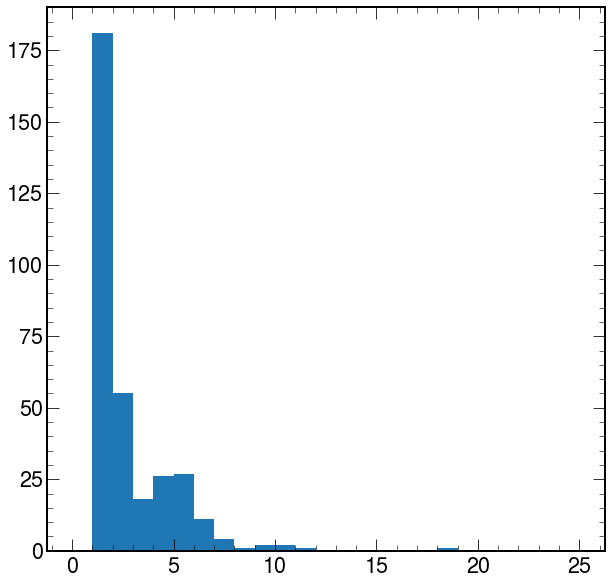

In [86]:
bin_test = np.linspace(0,25,26)
plt.hist(wg[0], bins = bin_test) 

In [87]:
%%time
lumi_path="/hadoop/cms/store/user/hmei/lumi/output_byls_2018ABCD_hzub_clean.csv"
futures = []
for chunk in chunks:
    if int(chunk[2]) < 1e4: continue
    future = c.submit(doCSCAll_wire, chunk)#, pure=False)
    futures.append(future)

#results = c.gather(futures)
#len(results)


CPU times: user 185 ms, sys: 42.2 ms, total: 228 ms
Wall time: 214 ms


In [88]:
progress(futures)

VBox()

In [89]:
%%time
results = c.gather(futures)

CPU times: user 11min 26s, sys: 52.9 s, total: 12min 19s
Wall time: 1h 11min 21s


In [101]:
results[1][0][1]
15/5920/6/125*1e9

3378.378378378379

In [144]:
%%time
from datetime import datetime
datetime.now(tz=None)

ncsc_per_type = {"1_1": 36, "1_2": 36, "1_3": 36, "1_4": 36,
                 "2_1": 18, "3_1": 18, "4_1": 18,
                 "2_2": 36, "3_2": 36, "4_2": 36}

comb_s_r = [(1,1), (1,2), (1,3), (1,4), (2,1), (2,2), (3,1), (3,2), (4,1), (4,2)]
cscarea_bytype = {}

#this is consider ME1/1a and b, but for wire group a and b are merged
#areas = [4660.0, 2340.0, 13550.0, 1260.0, 18080.0,
#         32280.000000000004, 16870.0, 32280.000000000004, 15500.0, 32280.000000000004]
areas = [5920.0, 2340.0, 13550.0, -1.0, 18080.0,
         32280.000000000004, 16870.0, 32280.000000000004, 15500.0, 32280.000000000004]
#[cscarea_bytype[comb_s_r[i]] = areas[i] for i in range(len(comb_s_r))]

for i in range(len(comb_s_r)):
  cscarea_bytype[comb_s_r[i]] = areas[i]  

nType = len(comb_s_r)
## should turn these two into hist directly

bin_rate = np.linspace(0,5000,51)
bin_nwg = np.linspace(0,20,21)
bin_lumi = np.linspace(8,20,26)
hists_nwg_lumi = [ Hist2D(np.c_[np.array([]), np.array([])], bins=[bin_lumi, bin_rate]) for i in range(len(ncsc_per_type))]
hists_nwg = [ Hist1D(np.array([]), bins=bin_nwg) for i in range(len(ncsc_per_type))]

outter_counter = 0
for result in results:
    outter_counter += 1
    dateTimeObj = datetime.now()
    print (outter_counter, dateTimeObj)
    counter = 0
    for endcap in range(1,3):
        for station in range(1,5):
            for ring in range(1,5):
                if station > 1 and ring > 2: continue
                for chamber in range(1, ncsc_per_type[str(station) + "_" + str(ring)]+1):
                    # calculate rate: nwg/area/ntimbin (currently: 5*25ns = 125)
                    wg = result[0][counter]/cscarea_bytype[(station, ring)]/6/125*1e9
                    wg_raw = result[0][counter]
                    #print (wg)
                    lumi = result[1][counter]
                    index = comb_s_r.index((station, ring))
                    hists_nwg_lumi[index] += Hist2D(np.c_[lumi,wg], bins=[bin_lumi, bin_rate])
                    hists_nwg[index] += Hist1D(wg_raw, bins=bin_nwg)
                    counter += 1 

1 2020-11-16 00:58:23.636593
2 2020-11-16 00:58:24.686313
3 2020-11-16 00:58:25.694956
4 2020-11-16 00:58:26.733564
5 2020-11-16 00:58:27.806851
6 2020-11-16 00:58:28.911685
7 2020-11-16 00:58:30.032166
8 2020-11-16 00:58:31.017372
9 2020-11-16 00:58:32.066509
10 2020-11-16 00:58:33.062243
11 2020-11-16 00:58:34.074947
12 2020-11-16 00:58:35.072528
13 2020-11-16 00:58:36.149954
14 2020-11-16 00:58:37.194964
15 2020-11-16 00:58:38.201114
16 2020-11-16 00:58:39.289126
17 2020-11-16 00:58:40.320259
18 2020-11-16 00:58:41.299471
19 2020-11-16 00:58:42.280155
20 2020-11-16 00:58:43.271154
21 2020-11-16 00:58:44.284394
22 2020-11-16 00:58:45.378320
23 2020-11-16 00:58:46.376870
24 2020-11-16 00:58:47.433738
25 2020-11-16 00:58:48.485506
26 2020-11-16 00:58:49.537608
27 2020-11-16 00:58:50.606068
28 2020-11-16 00:58:51.680632
29 2020-11-16 00:58:52.746264
30 2020-11-16 00:58:53.741274
31 2020-11-16 00:58:54.783501
32 2020-11-16 00:58:55.795177
33 2020-11-16 00:58:56.801862
34 2020-11-16 00:58

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


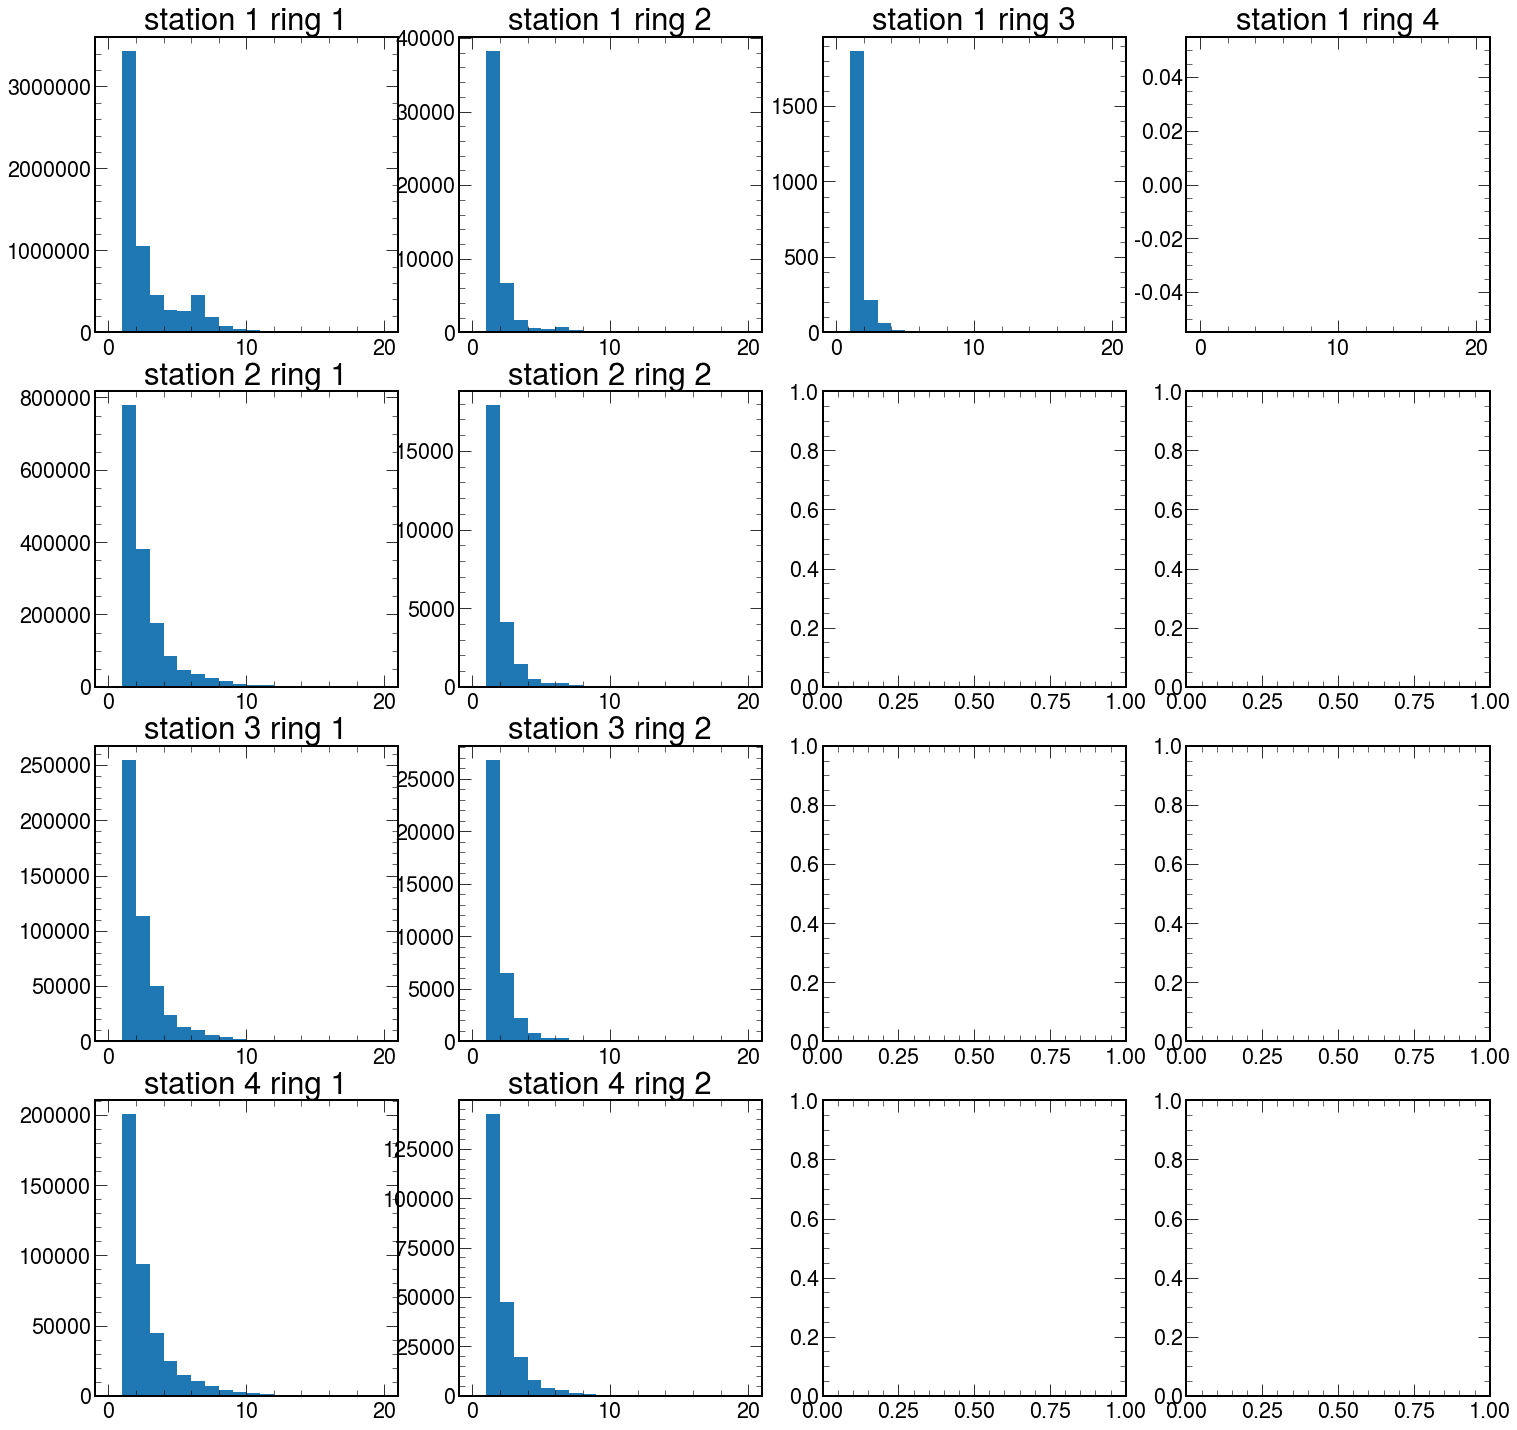

In [165]:
figwg, axswg = plt.subplots(4,4, figsize=(25,25))

#[hists_nwg_lumi[i].profile("x").plot(axswglumi[comb_s_r[i][0]-1][comb_s_r[i][1]-1],show_counts=True,show_errors=True) for i in range(len(comb_s_r))]
[hists_nwg[i].plot(axswg[comb_s_r[i][0]-1][comb_s_r[i][1]-1]) for i in range(len(comb_s_r))]

[axswg[comb_s_r[i][0]-1][comb_s_r[i][1]-1].set_title("station " + str(comb_s_r[i][0]) + " ring " + str(comb_s_r[i][1])) for i in range(len(comb_s_r))]
#[axswg[comb_s_r[i][0]-1][comb_s_r[i][1]-1].set_xlabel("nWireHits") for i in range(len(comb_s_r))]
#[axswg[comb_s_r[i][0]-1][comb_s_r[i][1]-1].set_ylabel("Events") for i in range(len(comb_s_r))]

plt.savefig("/home/users/hmei/public_html/plotDump/nWGHit_20201116.pdf", bbox_inches='tight')

In [ ]:
figwglumi, axswglumi = plt.subplots(4,4, figsize=(25,25))
fit_res = []
#[hists_nwg_lumi[i].profile("x").plot(axswglumi[comb_s_r[i][0]-1][comb_s_r[i][1]-1],show_counts=True,show_errors=True) for i in range(len(comb_s_r))]
#[hists_nwg_lumi[i].profile("x").plot(axswglumi[comb_s_r[i][0]-1][comb_s_r[i][1]-1],show_errors=True) for i in range(len(comb_s_r))]
#[hists_nwg_lumi[i].profile("x").fit("a*x+b") for i in range(len(comb_s_r)) if not i==3]
for i in range(len(comb_s_r)):
    hists_nwg_lumi[i].profile("x").plot(axswglumi[comb_s_r[i][0]-1][comb_s_r[i][1]-1],show_errors=True)  
    if not i == 3:
        fit_res_tmp = hists_nwg_lumi[i].profile("x").fit("a*x+b", ax=axswglumi[comb_s_r[i][0]-1][comb_s_r[i][1]-1])
        fit_res.append(fit_res_tmp) 
[axswglumi[comb_s_r[i][0]-1][comb_s_r[i][1]-1].set_title("station " + str(comb_s_r[i][0]) + " ring " + str(comb_s_r[i][1])) for i in range(len(comb_s_r))]
#[axswglumi[comb_s_r[i][0]-1][comb_s_r[i][1]-1].set_xlim(0,80) for i in range(len(comb_s_r))]
#[axswglumi[comb_s_r[i][0]-1][comb_s_r[i][1]-1].set_ylim(0,1000) for i in range(len(comb_s_r))]
#[axswglumi[comb_s_r[i][0]-1][comb_s_r[i][1]-1].set_xlabel("Luminosity (1E33 cm^{-2}s^{-1})") for i in range(len(comb_s_r))]
#[axswglumi[comb_s_r[i][0]-1][comb_s_r[i][1]-1].set_ylabel("rate (Hz/cm^{2})") for i in range(len(comb_s_r))]

plt.savefig("/home/users/hmei/public_html/plotDump/nWGHitLumi_20201116.pdf", bbox_inches='tight')

/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/yahist/hist2d.py:176: RuntimeWarning: invalid value encountered in true_divide
  r_val = num / den
/home/users/hmei/miniconda3/envs/analysisenv/lib/python3.8/site-packages/yahist/hist2d.py:177: RuntimeWarning: invalid value encountered in true_divide
  r_err = ((num_err / den) ** 2 + (den_err * num / den ** 2.0) ** 2.0) ** 0.5
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


In [142]:
comb_s_r = [(1,1), (1,2), (1,3), (1,4), (2,1), (2,2), (3,1), (3,2), (4,1), (4,2)]
dict( fit_res[0] )
counter = 0
for i in range(len(comb_s_r)):
    if i == 3: continue
    print (comb_s_r[i], fit_res[counter]['parvalues'][0]*75 + fit_res[counter]['parvalues'][1])
    counter += 1

(1, 1) 1042.0424070757808
(1, 2) 1240.3914664545455
(1, 3) 69.82637658714927
(2, 1) 416.087083720488
(2, 2) 85.39216368746943
(3, 1) 339.65795982941665
(3, 2) 84.97872589736804
(4, 1) 432.8487333189323
(4, 2) 113.59682152096187


### test area

In [ ]:
ncsc_per_type = {"1_1": 36, "1_2": 36, "1_3": 36, "1_4": 36,
                 "2_1": 18, "3_1": 18, "4_1": 18,
                 "2_2": 36, "3_2": 36, "4_2": 36}
cscID_comb = []
for endcap in range(1,3):
    for station in range(1,5):
        for ring in range(1,5):
            if station > 1 and ring > 2: continue
            for chamber in range(1, ncsc_per_type[str(station) + "_" + str(ring)]+1):
                                 cscID_comb.append((endcap, station, ring, chamber))
                    
bin_nrh = np.linspace(0,50,51)
bin_lumi = np.linspace(0,25,26)
hists_nrh_lumi = [ Hist2D(np.c_[np.array([]), np.array([])], bins=[bin_lumi, bin_nrh]) for i in range(len(cscID_comb))]
                    
## to be understood how to use, but seems a very efficient tool
from dask.distributed import as_completed

#futures,results = as_completed(futures, with_results=True)
# a global histogram

counter = 0
for future, result in as_completed(futures, with_results=True):
    # a local histogram
    if type(result) == int: continue 
    nrh_tmp = result[0] 
    lumi_tmp = result[1]
    hist_local = [ Hist2D(np.c_[nrh_tmp[i], lumi_tmp[i]], bins=[bin_lumi, bin_nrh]) for i in range(len(cscID_comb))]
    # update global histogram
    for i in range(len(hists_nrh_lumi)):
        hists_nrh_lumi[i] += hist_local[i] 
    print (counter)
    counter += 1
    

In [72]:
c.retire_workers(workers=["tcp://169.228.131.121:32811"])

()

In [ ]:
## send task to workers who has run it before
d = c.who_has(futures)
workers = [set(d[f.key]) for f in futures]
futures = c.map(doCSCAll,chunks,workers=workers,pure=False)

In [11]:
len(results)

NameError: name 'results' is not defined

## test area

In [31]:
fname = chunks[0][0]

f = uproot4.open("/hadoop/cms/store/user/hmei/rawreco_runII/zerobias/ZeroBias_Run2018D-LogError-PromptReco-v2_RAW-RECO_v0.1_20201103/test_rawreco_21.root")
t = f["cscRootMaker/Events"]

keys_tosave = ["Event", "Run", "LumiSect" 
#           "muons_cscSegmentRecord_endcap", 
#           "muons_cscSegmentRecord_station",
#           "muons_cscSegmentRecord_ring", 
#           "muons_cscSegmentRecord_chamber",
#           "muons_nMuons"
          ]



In [41]:
%%time

events = t.arrays( keys_tosave + t.keys(filter_name="recHits2D_*") + t.keys(filter_name="muons_*"), library="ak", how="zip")
#museg_endcap = events_withmu.muons_cscSegmentRecord_endcap #[ (events_withmu.muons_nMuons > 0) ]


CPU times: user 3.58 s, sys: 434 ms, total: 4.01 s
Wall time: 3.51 s


In [51]:
## get nevts with muon/without muon
mask_noMuon = (events.muons_nMuons == 0)
nevts = len(events)
nevts_noMuon = len(events[mask_noMuon])
print ("nEvts total: ", nevts, ", nEvts without muon: ", nevts_noMuon)

## get nevts with/without muon-csc segment
mask_muCSCSeg = (events.muons.numberOfSegments > 0)
nmucscseg = ak.num(events.muons[mask_muCSCSeg])

unique_elements, counts_elements = np.unique(ak.to_numpy(nmucscseg), return_counts=True)
print ("nmucscseg in evt", unique_elements)
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
print ("fraction of evt", counts_elements/nevts*100 )

## estimate total number of chamber having rechits in this tree
mask_ME11 = (events.recHits2D.ID_station == 1) & (events.recHits2D.ID_station == 1) & \
            (events.recHits2D.ID_endcap == 1) & (events.recHits2D.ID_chamber == 16)

nME11 = ak.num(events.recHits2D[mask_ME11])
print (nME11, len(mask_ME11))
#print (nME11, ak.to_list(mask_ME11)[0])

nEvts total:  19102 , nEvts without muon:  1412
nmucscseg in evt [0 1 2 3 4]
fraction of evt [78.45 18.45 2.66 0.39 0.05]
[0, 0, 0, 0, 0, 0, 0, 14, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 19102


In [42]:
len(results[0])

184429

In [127]:
#c.retire_workers(workers=["tcp://169.228.132.133:35208"])
#c.retire_workers(workers=["tcp://169.228.130.147:43912"])
#c.retire_workers(workers=["tcp://169.228.131.228:42111"])
c.retire_workers(workers=["tcp://169.228.131.234:1145"])
#c.processing().items()
#def f():
#    import subprocess
#    return subprocess.getoutput("grep ProcId $_CONDOR_JOB_AD")
#c.run(f)

()